# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

## Introduction

### Project Overview

*Sparkify* is an imaginary music streaming service of Udacity to emulate a real streaming service like Spotify. The Sparkify users can stream the music using the free subscription plan with ads or paid subscription plan without ads. Apart from using the service to listen to the music, users can thumb up or down, add songs to playlists, or add friends. Users are free to change their subscription plan by *upgrading* from free to paid, by *downgrading* from paid to free, or to entirely stop using the service by *cancelling* the subscription. 

Any user interaction with the service triggers a certain log event that represents our data. A log contains information about the event time, identifies the session and the user, includes some of user attributes, subscription plan, user interaction type etc. 

There are 3 datasets with event log information available for our project: 
 - **full** (big) dataset of 12GB available on Amazon EMR cluster, 
 - **medium** dataset available on IBM Watson cluster, 
 - **mini** (sample) dataset available on local machine. 
 
We'll use the mini dataset to get used to our data and to carry out all the necessary preparation work before moving to Amazon EMR cluster where the "real" job will be done. Since we are working with huge amount of data we'll be using **Apache Spark** analytics engine for processing large datasets with Spark SQL query language for structured data processing.

### Problem statement

Business-wise, the word "**churn**" is used to refer to customers that leave the company’s service over a given time period. The businesses strive to identify the potential users who are likely to leave *before* they actually leave the service in order to take actions to retain them. Some estimate that it may costs five or six times as much to acquire a new customer than it does to retain the ones you have (https://baremetrics.com/academy/churn).

Our churned users are defined as those who **downgrade** or **cancel** the subscription. For the reasons explained later on *we will not mix* users who cancelled the subscription with users who downgraded. We’ll separately address these two churn types of users.

The identification of potential churned users is a **binary classification problem**: either a user is *churned* or *non-churned*. In order to be able to properly classify users we will perform exploratory data analysis against sample data, then we’ll engineer the features that we will find important for churn classification, and finally, we’ll exercise modelling with selected features using various learning methods. 

The solution of our problem is to create a **machine learning model** that can provide prediction results achieving the *project goal* according to the chosen metrics as described in the next section.

### Metrics

Choosing the right metrics is essential for the machine learning model evaluation. Our full dataset has *22,278* users out of which *5,003* are cancelled users (*22.46%*). If we use **accuracy** to measure the prediction quality of our model and our model identifies every users as a *non-churned* we achieve accuracy of *77.54%* which is pretty high value for a blind model that always predicts 0. 

The problem we have is that the class of churned users is **imbalanced** due to its unequal distribution in the dataset. In case of imbalanced classes the accuracy is misleading and shouldn't be used. 

We will use the **precision-recall** metrics instead. The *precision* tells us the proportion how many churned users we successfully identified among all users that we identified as churned while the *recall* tells us the proportion how many churned users we successfully identified among all churned users:

> precision = $\frac{TP}{TP+FP}$

> recall = $\frac{TP}{TP+FN}$

*TP* are *true positives* or correctly identified churned users, *FP* are *false positives* or non-churned users incorrectly identified as churned users, and *FN* are *false negatives* or churned users incorrectly identified as non-churned users.

Normally, the classes are *not perfectly distributed*. Not in all cases we can clearly separate all points of a possitive class from all points of a negative class, so there will always be a certain grey zone where classes are mixed together. The inevitable consequence is an *inverse relationship* between the precision and recall: by increasing one parameter (precision or recall) the other parameter decreases (recall or precision). This is known as **precision-recall tradeoff**. 

Due to a high level of abstraction that we persue in this study we cannot focus on a specific business situation with a clear posture towards the precision-recall tradeoff. Our study is not focused on businesses that are willing to reduce churn at any cost no matter how many non-churned users we indentify as churned (*low precision*) as long as we include all churned users (*high recall*). In similar but opposite sense we are not focused on businesses that want to pinpoint with *high precision* the churned users minimizing the presence of non-churned users in the target and so investing less money in churn reduction even if some churned users are left out of the target (*lower recall*).  

In other words, we want to achieve a **balanced result** between the both precision-recall metrics. We don't want to have neigher too many false positives nor too many false negatives. For that reason we will use **F1-score** as our *principal metric* defined as:

> F1 = $2 * \frac{precision*recall}{precision+recall}$

F1 is the harmonic mean of precision and recall, it combines both metrics in a single metric giving an *equal weight* to both of them - which is precisely what we need.

### Project goal

**Our project is all about the prediction ability.** After all, what is it good for all the data exploratory work, all the feature engineering creativity and nice-looking code if at the end our model doesn't work?  

The project goal is to reach **0.9** of F1-score. We'll be also satisfied with a bit lower value but we'll definetely not be satisfied with the value below **0.8**. 

In [2]:
# Import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, \
                                  avg, from_unixtime, split, min, max, lit, mean
from pyspark.sql.functions import sum as Fsum, abs as Fabs, round as Fround
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window

from pyspark.sql.types import IntegerType, TimestampType
import datetime
from pyspark.sql.functions import to_date, year, month, dayofmonth, dayofweek, hour, date_format, substring

import math
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sb

In [3]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [4]:
# Set time parser policy
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
# Load dataset
path = "data/mini_sparkify_event_data.json"
data = spark.read.json(path)
original_count = data.count()
data.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

### Data set size and schema

In [6]:
# Dataset size
print(f'Row count: {original_count}')
print(f'Column count: {len(data.columns)}')

Row count: 286500
Column count: 18


In [7]:
# Schema
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### Columns description

In [8]:
def unique(data, column):
    """Return unique values with row count of a given column in the data set.
    
    Args:
        data (DataFrame): The data set. 
        column (str): The name of a target column.

    Returns:
        DataFrame: A dataframe query sorted by count descending.
    """
    return data.groupby(column).count().sort(desc('count'))

**artist**: Interpreter(s) of a song. Is given only when the music is played (on *NextSong* event).

**auth**: The authentication level

In [9]:
unique(data, 'auth').show()

+----------+------+
|      auth| count|
+----------+------+
| Logged In|278102|
|Logged Out|  8249|
|     Guest|    97|
| Cancelled|    52|
+----------+------+



**firstName**: The first name of a user

**gender**: The gender of a user

In [10]:
unique(data, 'gender').show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
|  null|  8346|
+------+------+



**itemInSession**: The zero-based index of a log event in a sesion

In [11]:
data.where(data.sessionId == 31).select('ts', 'itemInSession', 'page').sort('ts').show(5)

+-------------+-------------+---------+
|           ts|itemInSession|     page|
+-------------+-------------+---------+
|1539003534000|            0| NextSong|
|1539003736000|            1| NextSong|
|1539003932000|            2| NextSong|
|1539003933000|            3|Thumbs Up|
|1539004195000|            4| NextSong|
+-------------+-------------+---------+
only showing top 5 rows



**lastName**: The last name of a user

**length**: The length of a song (in seconds)

**level**: The subscription level of a user

In [12]:
unique(data, 'level').show()

+-----+------+
|level| count|
+-----+------+
| paid|228162|
| free| 58338|
+-----+------+



**location**: The location of a user (containing *city*, *state*)

In [13]:
unique(data, 'location').show(5, False)

+-------------------------------------+-----+
|location                             |count|
+-------------------------------------+-----+
|Los Angeles-Long Beach-Anaheim, CA   |30131|
|New York-Newark-Jersey City, NY-NJ-PA|23684|
|Boston-Cambridge-Newton, MA-NH       |13873|
|Houston-The Woodlands-Sugar Land, TX |9499 |
|null                                 |8346 |
+-------------------------------------+-----+
only showing top 5 rows



**method**: The http request method

In [14]:
unique(data, 'method').show()

+------+------+
|method| count|
+------+------+
|   PUT|261064|
|   GET| 25436|
+------+------+



**page**: The type of a user interaction

In [16]:
unique(data, 'page').show(30, False)

+-------------------------+------+
|page                     |count |
+-------------------------+------+
|NextSong                 |228108|
|Home                     |14457 |
|Thumbs Up                |12551 |
|Add to Playlist          |6526  |
|Add Friend               |4277  |
|Roll Advert              |3933  |
|Login                    |3241  |
|Logout                   |3226  |
|Thumbs Down              |2546  |
|Downgrade                |2055  |
|Help                     |1726  |
|Settings                 |1514  |
|About                    |924   |
|Upgrade                  |499   |
|Save Settings            |310   |
|Error                    |258   |
|Submit Upgrade           |159   |
|Submit Downgrade         |63    |
|Cancellation Confirmation|52    |
|Cancel                   |52    |
|Register                 |18    |
|Submit Registration      |5     |
+-------------------------+------+



**registration**: The timestamp of a user registration

**sessionId**: The identifier of a user session

**song**: The name of a song

In [17]:
unique(data.where(data.userId == 100001), 'song').show(5, False)

+------------------------------------+-----+
|song                                |count|
+------------------------------------+-----+
|null                                |54   |
|You're The One                      |3    |
|Sehr kosmisch                       |2    |
|Undo                                |2    |
|Kids With Guns (Quiet Village Remix)|1    |
+------------------------------------+-----+
only showing top 5 rows



**status**: The http response status code

In [18]:
unique(data, 'status').show(5, False)

+------+------+
|status|count |
+------+------+
|200   |259812|
|307   |26430 |
|404   |258   |
+------+------+



**ts**: The timestamp of an event log

**userAgent**: The user's agent used to access the streaming service 

**userId**: The identifier of a user

### Duplicate rows

In [19]:
# Any duplicate rows? - No
print(f'Duplicate rows: {data.count() - data.dropDuplicates().count()}')

Duplicate rows: 0


### Missing values

In [20]:
def filter_missing(data, column):
    """Returns rows with missing values for a given column where a missing value
    is either null or empty string.
    
    Args:
        data (DataFrame): The data set.
        column (str): The name of a target column.    
        
    Returns:
        DataFrame: A dataframe query with missing values.
    """
    return data.where((col(column).isNull()) | (col(column) == ''))

def show_missing(data):
    """Shows the count of missing values for every column in a given data set.
    
    Args:
        data (DataFrame): The data set.
        
    Returns:
        None
    """
    for field in data.schema:
        print(f'{field.name}: {filter_missing(data, field.name).count()}')

In [21]:
show_missing(data)

artist: 58392
auth: 0
firstName: 8346
gender: 8346
itemInSession: 0
lastName: 8346
length: 58392
level: 0
location: 8346
method: 0
page: 0
registration: 8346
sessionId: 0
song: 58392
status: 0
ts: 0
userAgent: 8346
userId: 8346


Let's check if 8346 missing values in the user-related columns (*firstName*, *gender*, *lastName*, *location*, *registration*, *userAgent*, *userId*) belong to the same rows:

In [282]:
class Missing:
    """A helper class to simplify filtering the missing values.  
    
    Attributes:
        missing_data: A dataframe query that is built by filter_missing function.   
    """
    missing_data = None
    
    def __init__(self, data):
        self.missing_data = data
        
    def filter_missing(self, name):
        """A method that filters the missing values.
        
        We can use this method in a consecutive manner.
        
        Args:
            name (str): The name of a column to filter.
            
        Returns:
            DataFrame: A dataframe query with missing values.
        """
        self.missing_data = filter_missing(data, name) 
        return self  

In [23]:
m = Missing(data) \
    .filter_missing('userId') \
    .filter_missing('firstName') \
    .filter_missing('lastName') \
    .filter_missing('gender') \
    .filter_missing('location') \
    .filter_missing('registration') \
    .filter_missing('userAgent')
print(f'Missing count: {m.missing_data.count()}')

Missing count: 8346


As the filtering criterion contains the logical conjunction of all user-related columns and the count result of missing values is the same as when a single user-related column is filtered we may conclude that the missing values occur **in the same rows**. This behaviour is in tune with the logic which tells us that if a user identifier is missing then also all related user attributes should be missing too. 

**What kind of a user has missing attributes?**

In [24]:
filter_missing(data, 'userId').select('auth').dropDuplicates().show()

+----------+
|      auth|
+----------+
|Logged Out|
|     Guest|
+----------+



In [25]:
filter_missing(data, 'userId').select('page').dropDuplicates().show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



Clearly, the missing user is an **unregistered** user. Then, since our target is a *churned* user which is a *registered* user, it is also clear that if we remove the rows with missing users *we will not remove any churned user*.

In [26]:
# Remove rows with the missing users
data = data.where(~((col('userId').isNull()) | (col('userId') == '')))
show_missing(data) 

artist: 50046
auth: 0
firstName: 0
gender: 0
itemInSession: 0
lastName: 0
length: 50046
level: 0
location: 0
method: 0
page: 0
registration: 0
sessionId: 0
song: 50046
status: 0
ts: 0
userAgent: 0
userId: 0


In [27]:
# Check count of deleted rows - OK
original_count - data.count()

8346

#### Remove unrelevant columns

We identify 2 columns that are not relevant for our analysis: *firstName* and *lastName*. In the perfect naming, the combination of this two columns would be the user's candidate key (which is actually the case with our mini data set - check below). However, we already have the unique identifier of a user - **userId**, so this two columns do not deliver any new information relevant for our analysis that is not already contained in the *userId* attribute.

In [28]:
# How many different keys (firstName, lastName) exist in our dataset?
data.select('firstName', 'lastName').dropDuplicates().count()

225

In [29]:
# Check if a composite key firstName-lastName is associated to exactly one userId
data.select('firstName', 'lastName', 'userid') \
    .dropDuplicates() \
    .groupby('firstName', 'lastName') \
    .count() \
    .where(col('count') > 1) \
    .count()

0

In [30]:
# Drop redundant columns
data = data.drop('firstName')
data = data.drop('lastName')

#### Add *tsDate* and *date* columns

In [31]:
data = data.withColumn('tsDate', (col('ts') / 1000.0).cast(TimestampType()))
data = data.withColumn('date', to_date('tsDate'))
data.take(1)

[Row(artist='Martha Tilston', auth='Logged In', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', tsDate=datetime.datetime(2018, 10, 1, 2, 1, 57), date=datetime.date(2018, 10, 1))]

#### Split *location* column into *city* and *state* columns

The location column contains *place* and *state*. Let's split the composed information into 2 features and drop the original column.

In [32]:
data = data.withColumn('city', split(data['location'], ',')[0])
data = data.withColumn('state', split(data['location'], ',')[1])
data = data.drop('location')

In [34]:
# Schema after the cleaning is done
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- tsDate: timestamp (nullable = true)
 |-- date: date (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [39]:
# Set plot's figure size
def set_plot_size(width, height):
    """Set plot's figure size.
    
    This function does not contribute anything special to the code here.
    (It is just a small coding simplification that I myself find useful.)
    
    Args:
        width (int): The width of a figure.
        height (int): The height of a figure.
        
    Returns:
        Figure: The figure instance.
    """
    return plt.figure(figsize = [width, height]);

def get_categories(data, column):
    """Creates a list of column's categories.
    
    Args:
        data (DataFrame): The data set. 
        column (str): The name of a target column.

    Returns:
        list: A list of column categories. 
    """   
    return [str(row[column]) for row in unique(data, column).collect()]

## Preliminary Analysis

In [35]:
# Count of unique users
data.select('userId').dropDuplicates().count()

225

In [36]:
# Count of unique sessions
data.select('sessionId').dropDuplicates().count()

2312

In [37]:
# Total observation period
data.select(to_date(min('tsDate')).alias('MinDate'), to_date(max('tsDate')).alias('MaxDate')).show()

+----------+----------+
|   MinDate|   MaxDate|
+----------+----------+
|2018-10-01|2018-12-03|
+----------+----------+



### Log level
A *log level* is a level without any aggregation. All rows of our dataset concerning the information level belong to the log level.

#### *level*, *status*

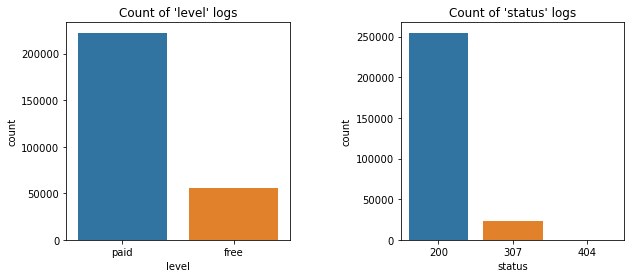

In [44]:
fig = set_plot_size(10, 4);
plt.subplots_adjust(wspace=0.5)

# 1. Count log events by level attribute (paid, free) 
df = data.select('level').toPandas()
plt.subplot(1, 2, 1)
sb.countplot(data = df, x = 'level');
ax = plt.gca()
ax.set_title("Count of 'level' logs");

# 2. Count log events by status categories
df = data.select('status').toPandas()
plt.subplot(1, 2, 2)
sb.countplot(data = df, x = 'status');
ax = plt.gca()
ax.set_title("Count of 'status' logs");

#### *page*

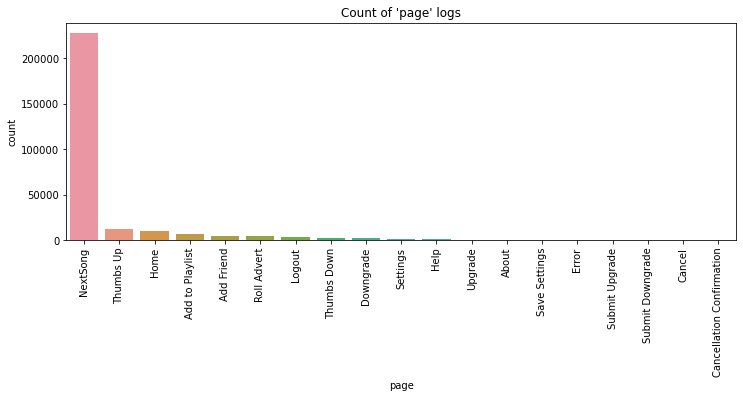

In [45]:
set_plot_size(12, 4)
df = data.select('page').toPandas()
sb.countplot(data = df, x = 'page', order = df['page'].value_counts().index);
plt.xticks(rotation = 90);
ax = plt.gca()
ax.set_title("Count of 'page' logs");

### User level
A *user level* is a level where data is aggregated by *userId*. We have already met the *user-related* columns which are *userId*-dependent since their value does not change if a log event changes unless the *userId* attribute changes. 

In [46]:
def plot_hist_with_boxplot(df, column, title, bins=15, ):
    """Plots a histogram with boxplot.
    
    Args:
        df (pandas DataFrame): The data set.
        column (str): The name of a target column.  
        title (str): The title of a plot.
        bins (int, optional): The number of histogram's bins.
        
    Returns:
        None
    """
    # Output statistics 
    print(df.describe())
    
    fig = set_plot_size(12, 4);
    spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[5, 1])
    plt.subplots_adjust(hspace=0.3)

    # Plot histogram + boxplot
    ax0 = fig.add_subplot(spec[0])
    ax0.hist(df[column], bins=15)
    ax0.set_title(title);
    plt.xlabel(column)
    plt.ylabel('frequency')
    ax1 = fig.add_subplot(spec[1])
    ax1.boxplot(df[column])

    plt.show()

#### *gender*

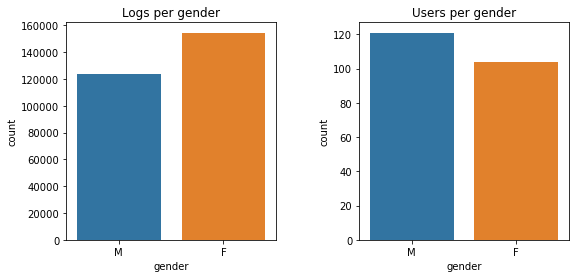

In [47]:
set_plot_size(9, 4);
plt.subplots_adjust(wspace=0.4)

# 1. Count logs per gender
df_gender_logs = data.select('gender').toPandas()
plt.subplot(1, 2, 1)
sb.countplot(data = df_gender_logs, x = 'gender', order = ['M','F']).set_title('Logs per gender');

# 2. Count users per gender
df_gender_users = data.groupby('userId', 'gender').count().toPandas()
plt.subplot(1, 2, 2)
sb.countplot(data = df_gender_users, x = 'gender', order = ['M','F']).set_title('Users per gender');

We have more male users but the female users are more active.

##### state

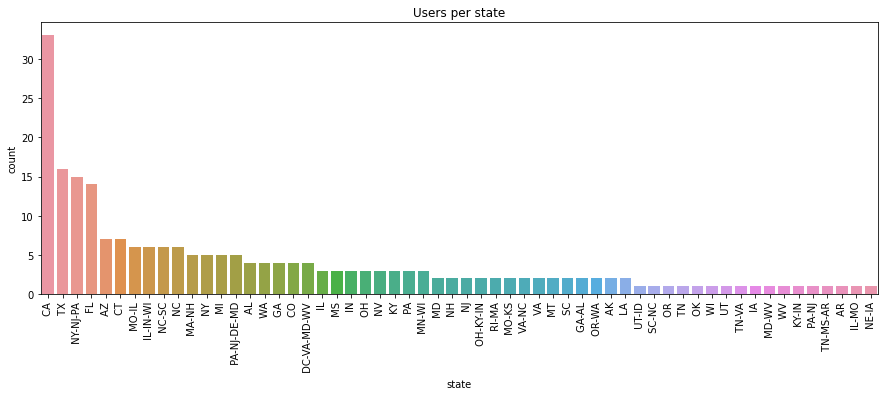

In [48]:
# Count users per state
df_user_state = data.select('userId', 'state').dropDuplicates().toPandas()

set_plot_size(15, 5);
data_order = df_user_state['state'].value_counts().index
sb.countplot(data = df_user_state, x = 'state', order = data_order).set_title('Users per state')
plt.xticks(rotation = 90);
plt.show()

##### Logs per user

             count
count   225.000000
mean   1236.240000
std    1329.531716
min       6.000000
25%     296.000000
50%     848.000000
75%    1863.000000
max    9632.000000


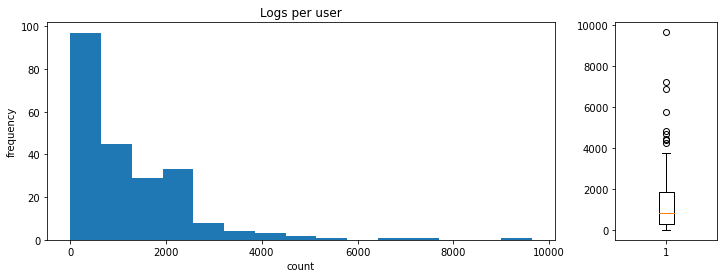

In [49]:
df_user_logs = data.groupby('userId').count().toPandas()
plot_hist_with_boxplot(df_user_logs, 'count', 'Logs per user')

The distribution of logs per user is **right-skewed**. Some extreme outliers can be detected. In general, we may expect that our statistical model will be negatively affected by these outliers.

#### User level: *Sessions per user*

            count
count  225.000000
mean    14.115556
std     14.646885
min      1.000000
25%      6.000000
50%     10.000000
75%     18.000000
max    107.000000


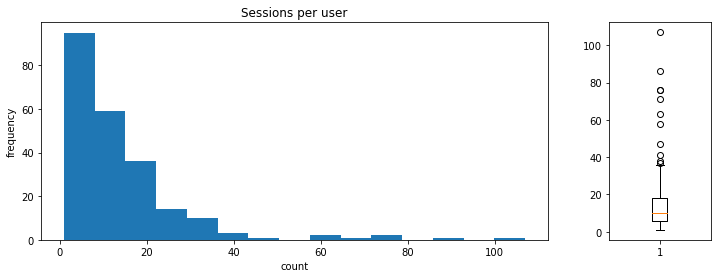

In [50]:
df_user_sessions = data.select('userId', 'sessionId').dropDuplicates().groupby('userId').count().toPandas()
plot_hist_with_boxplot(df_user_sessions, 'count', 'Sessions per user')

The distribution of sessions per user is similar to the distribution of logs per user - *right-skewed*. It is not surprising,  both distributions has a *lower bound* and the data with a lower bound tends to be right-skewed.

### Session level
A *session level* is a level where data is aggregated by *userId*, *sessionId*. Note that the *sessionId* attribute is not a unique identifier of a session; it is unique only for a single user, therefore, as alone cannot be used in a cross-user context.

In [51]:
# Check if two or more users can share the same sessionId - YES
data \
    .select('userId', 'sessionId').dropDuplicates() \
    .groupby('sessionId').count() \
    .where(col('count') > 1) \
    .show(5)

+---------+-----+
|sessionId|count|
+---------+-----+
|       65|    4|
|      418|    2|
|      191|    3|
|      270|    3|
|      293|    3|
+---------+-----+
only showing top 5 rows



##### Session duration (in min)

          duration
count  3176.000000
mean    299.518755
std     390.281555
min       0.000000
25%      58.129167
50%     160.541667
75%     381.283333
max    4455.083333


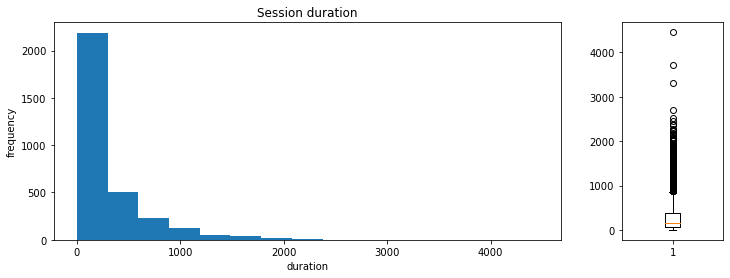

In [52]:
df_session_duration = data.groupby('userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/60000).alias('duration')) \
    .select('duration').toPandas()
plot_hist_with_boxplot(df_session_duration, 'duration', 'Session duration')

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [53]:
# Check count of cancelled users
cancelled = data.where(data.page == 'Cancellation Confirmation').select('userId').dropDuplicates()
cancelled.count()

52

In [54]:
# Check count of downgraded users
downgraded = data.where(data.page == 'Submit Downgrade').select('userId').dropDuplicates()
downgraded.count()

49

In [55]:
# Check count of users that downgrade AND cancel the subscription
downgraded.intersect(cancelled).count()

9

#### Decision: Churn type separation

We have **225** users in total. There are **52** users that cancelled the subscription and **49** users that downgraded. **9** users did both things. Already the number of all users is low, but with so small number of churned users it will be very difficult to create a reliable statistical model that will predict similarly in cases of different random data splits (different *seeds*). 

It could help us if the two churn types can be observed as a *single type*. In that case we would almost duplicate the churn sample. However, before unite both types we have to check if the *cancelled* and *downgraded* users share the **similar statistics**  relevant for our model.

             count
count    52.000000
mean    862.769231
std     852.262378
min      11.000000
25%     208.750000
50%     576.000000
75%    1154.000000
max    3603.000000


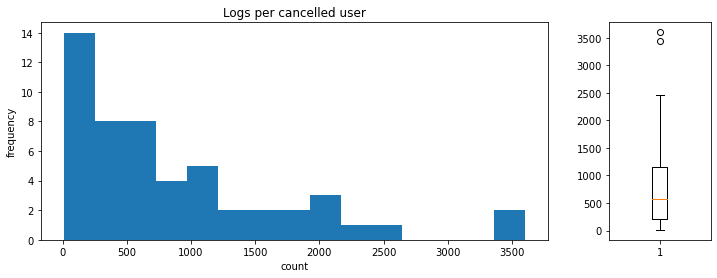

             count
count    49.000000
mean   2176.571429
std    1904.991175
min     262.000000
25%     977.000000
50%    1570.000000
75%    2335.000000
max    9632.000000


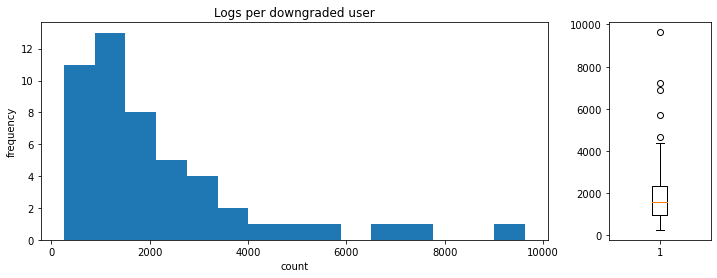

In [56]:
df_user_logs_cancelled = data \
    .where(data.userId.isin([row.userId for row in cancelled.collect()])) \
    .groupby('userId').count().toPandas()

df_user_logs_downgraded = data \
    .where(data.userId.isin([row.userId for row in downgraded.collect()])) \
    .groupby('userId').count().toPandas()
           
plot_hist_with_boxplot(df_user_logs_cancelled, 'count', 'Logs per cancelled user')
plot_hist_with_boxplot(df_user_logs_downgraded, 'count', 'Logs per downgraded user')

Well, the *logs per user* statistics of both churn types *differs considerebly*. All the statisticals values shows huge discrepancies: the *cancelled* users have **863** logs on average, the *downgraded* users generates much more logs - **2177** on average which is **2.5** times higher value. The similar behaviour can be found with other statistical values.

The **log count statistics** using the *unaggregated* source data is the most basic statistics we can do. If the two types of churned users do not share the same basic statistics then it is very likely that we face the discrepancies on certain aggregation levels. As we persue a goal to predict well we opt **not to unite both types**. 

We will follow the Udacity suggestion to focus on the first type - the **cancelled** users. Later on when we'll move to the big data set on cluster we will consider incorporating the downgraded users in order to check if this initial assumption about the *two distinctive churn types* that we are making here is correct. 

In [57]:
def get_users(churn):
    """Returns unique users of a specified churn group.
    
    Args:
        churn (int): The churn column with Boolean values (0 - non-churned, 1 - churned).
        
    Returns:
        DataFrame: A dataframe query.
    """
    return data.where(data.churn == churn).select('userId').dropDuplicates()

#### Churn of cancelled users

We'll label the *churned* users by **1**, and the *non-churned* users by **0**. Similarly, the variables with the suffix "1" will represent the *churned* users while the variables with the suffix "0" will represent the *non-churned* users. 

According to our terminology, the term "**churn group/class**" which stands for our classification target (*churned*, *non-churned*) shouldn't be confused with the term "**churn type**" which refers to two supposedly distinctive target groups of *cancelled* and *downgraded* users which require separate modelling.

In [59]:
# Label churned (canceled) users
cancelled_uids = [row.userId for row in cancelled.collect()];
set_churn = udf(lambda x: 1 if x in cancelled_uids else 0, IntegerType())
data = data.withColumn('churn', set_churn('userId'))
print(f"Churned users who cancelled subscription: {get_users(1).count()}")

Churned users who cancelled subscription: 52


In [60]:
# Add [userRowId] column that assigns a 1-based index to every user's log ordered by [ts]
w =  Window.partitionBy(data.userId).orderBy('ts', 'itemInSession')
data = data.withColumn('userRowId', row_number().over(w))

# Add [userRowDescId] column that assigns a 1-based index to every user's log ordered by [ts] descending.
w =  Window.partitionBy(data.userId).orderBy(col('ts').desc(), col('itemInSession').desc())
data = data.withColumn('userRowDescId', row_number().over(w))

In [61]:
# Add lastLevel column
last_levels = dict()
for row in data.where(data.userRowDescId == 1).select('userId', 'level').collect():
    last_levels[row.userId] = row.level
get_level = udf(lambda userId: last_levels[userId])
data = data.withColumn('lastLevel', get_level('userId'))
data.take(1)

[Row(artist=None, auth='Logged In', gender='F', itemInSession=34, length=None, level='free', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', tsDate=datetime.datetime(2018, 11, 21, 19, 12, 32), date=datetime.date(2018, 11, 21), city='Bridgeport-Stamford-Norwalk', state=' CT', churn=0, userRowId=381, userRowDescId=1, lastLevel='free')]

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

<a id="section-general-statistical-method"></a>
### General statistical method
Let us describe the *general statistical method* with its simple mathematics that will be used in any exploratory analysis throughout the project.

A certain **feature** $f$ of a user $x$

> $f(x)$

can be important for our learning model only if it can serve us to "distinguish well" between the two churn groups (*churned*, *non-churned*). We use a certain *aggregation* (or **group**) function $g$ like *mean*

> $g(f, y)$  

where *y* is a **churn group** (1 or 0) to determine if the feature $f$ "distinguish well" between the two churn groups. The group function is applied over the subset of users that belong to a specified group *y*. If the absolute value of a difference between the aggregation values is "big enough"

> diff = $|g(f, 1) - g(f, 0)|$ 

we can say that the feature $f$ "distinguish well". However, in order to determine if the value *diff* is "big enough" we have to normalize it. Let

> $g_1$ = $g(f, 1)$ 

and 

> $g_2$ = $g(f, 0)$

Then a **ratio** of *churned* users (for a given feature $f$) is:

> $r_1$ = $\frac{g_1}{g_1 + g_0}$  

Similarly, a *ratio* of *non-churned* users is

> $r_0$ = $\frac{g_0}{g_1 + g_0}$  

Now, let us calculate the difference ($\Delta$) between the both ratios:

> $\Delta$ = $r_1$ - $r_0$ = $\frac{g_1 - g_0}{g_1 + g_0}$ 

which gives us a **ratio difference** with absolute values between 0 and 1. Note that we do not express the ratio difference as an *absolute value* since we want to preserve the sign which will tell as, if **positive**, that the feature $f$ for a group of churned users gives, on average (if *g* is a *mean* function), *higher values* than the same feature $f$ for a group of non-churned users, and, if **negative**, it gives *lower values*.
   
##### Delta threshold
Using the *delta* as a decisive factor for a feature selection is based on the idea that a certain feature is important for our model if and only if it can distinguish "well enough" beetwen the two churn groups. According to some preliminary tests we made with the sample dataset we have seen that a feature can work well for our learning model if the **delta threshold** is set to

> $|\Delta| > 0.20$

which means that there should be **at least 20% of difference** between the churn group ratios in order **to select the feature for our learning model**. 

##### Rational remark

We are aware that this statistical approach as described above which will give us some orientation how to engineer and select features is not a waterproof method that will hit the target *for any feature whose delta fulfills the threshold condition*. After all, it is just a statistical method **applied over a single, isolated feature**, that is to say, we make a simple one-dimensional calculation using one feature while the process of machine learning is far more complex where it is very difficult to forsee which features will serve best - *before the model fitting is actually done*.     

In [62]:
# Set the delta threshold
delta_threshold = 0.20

# List of churn groups (for bar plots)
churn_groups = ['churned', 'non-churned']

# Reverse list of churn groups (for histogram plots)
churn_groups_reverse = ['non-churned', 'churned']

#### $g$ function

> - The group function $g$ that we'll use in our project calculates the **mean** per churn group. 

In [63]:
def has_attribute(df):
    """Returns true if the data set contains attribute.
    
    Args:
        df (DataFrame): The data set.  
    
    Returns:
        bool: True if df contains an atribute or False if not. 
    """
    return 'attribute' in df.columns

In [64]:
def get_attribute(data, attribute):
    """Collects all unique values of a specified attribute.
    
    Args:
        data (DataFrame): The data set.
        attribute (str): The attribute column name.
        
    Returns:
        attribute (str): The attribute column name 
        list: The list of all unique values of an attribute.
    """
    attr_dict = dict()
    attr_dict['column'] = attribute
    attr_dict['values'] = [row[attribute] for row in unique(data, attribute).collect()]
    return attr_dict

In [65]:
def get_g(f, agg_method='avg'):
    """Gets the group function that returns the aggregated g-values of a feature per churn group. 
    By default the group function calculates mean.
    
    Args:
        f (DataFrame): The feature function dataframe which must contain the following columns:
                           - userId: user identifier
                           - churn: 1-churned, 0-non-churned
                           - f-value: value of an observing feature
                           - attribute (optional): value of an attribute
        agg_method (str, optional): Aggregation method of a g function. The default is 'avg' (mean).
        
    Returns:
        DataFrame: The group function result containing:
                       - churn: 1-churned, 0-non-churned
                       - g-value: value of a group function
                       - attribute (optional): value of an attribute column
    """
    if has_attribute(f) == True:
        return f \
            .groupby('churn', 'attribute') \
            .agg({'f-value': agg_method}) \
            .select('churn', 'attribute', col(f'{agg_method}(f-value)').alias('g-value')) \
            .sort('attribute', desc('churn'))
    else:
         return f \
            .groupby('churn') \
            .agg({'f-value': agg_method}) \
            .select('churn', col(f'{agg_method}(f-value)').alias('g-value')) \
            .sort(desc('churn'))

In [66]:
def calc_delta(g):
    """Calculates the ratios and delta of a feature. If an attribute is given the delta is calculated
    per attribute value.
    
    Args:
        g (DataFrame): The group function which should contain:
                         - churn: 1-churned, 0-non-churned users
                         - g-value: value of a group function
                         - attribute (optional): value of an attribute
        
    Returns:
        deltaset (DataFrame): The statistical result set with the following columns:
                                - churn: 1-churned, 0-non-churned
                                - g-value: result of a group function
                                - ratio: ratio of a feature
                                - delta: delta of a feature
                                - candidate: Is a candidate feature for the learning model?  
                                             (true if delta > delta_threshold; else false)
    """
    if has_attribute(g) == True:
        total = g.groupby('attribute').sum('g-value')
        deltaset = g \
            .join(total, g.attribute == total.attribute, 'inner') \
            .select(g['churn'], g['attribute'], g['g-value'], total['sum(g-value)']) \
            .withColumn('ratio', col('g-value')/col('sum(g-value)')) \
            .withColumn('delta', when(col('churn') == 1, 2 * (col('ratio') - 0.5)) \
                                 .otherwise(2 * (0.5 - col('ratio')))) \
            .withColumn('candidate', Fabs(col('delta')) > delta_threshold) \
            .drop('sum(g-value)') \
            .sort('attribute', desc('churn'))        
    else:   
        total = g.groupby().sum('g-value').first()['sum(g-value)']
        deltaset = g \
            .withColumn('ratio', col('g-value')/lit(total)) \
            .withColumn('delta', when(col('churn') == 1, 2 * (col('ratio') - 0.5)) \
                             .otherwise(2 * (0.5 - col('ratio')))) \
            .withColumn('candidate', Fabs(col('delta')) > delta_threshold) \
            .sort(desc('churn'))

    return deltaset

In [67]:
def plot_delta(deltaset, attr_dict=None, title='Analysis per churn group'
               , loc=1, width=None, height=None, rotation=0):
    """Plots the deltaset (bar plot).
    
    Args:
        deltaset (pandas DataFrame): The statistical data with g-values, ratios, and delta. 
        attr_dict (dict, optional): The attribute dictionary with column and values keys.
        title (str): The plot's title.
        loc (int, optional): The location of the plot's legend.
        width (int, optional): The plot width.
        height (int, optional): The plot height.
        rotation (int, optional): The label rotation of the plot's legend.
    Returns:
        None
    """             
    # Convert deltaset to pandas DataFrame and sort values by churn
    df = deltaset.toPandas().sort_values(by='churn', ascending=False)    
    w = 0.35
        
    if attr_dict == None:
        # split dataset into 2 churn subsets
        df1 = df[df.churn == 1]
        df0 = df[df.churn == 0]
        
        # Default width, height
        if width == None:
            width = 4
            height = 4

        set_plot_size(width, height)       
        labels = churn_groups
        plt.xticks([], [])
        plt.xlabel('')       
        middle_line_factor = 0.3
    else:  
        # Split dataset into 2 churn subsets
        df1 = df[df.churn == 1].sort_values(by='attribute')
        df0 = df[df.churn == 0].sort_values(by='attribute')
    
        # Default width, height
        if width == None:
            width = 8
            height = 4
    
        set_plot_size(width, height)    
        labels = attr_dict['values']
        plt.xticks(range(len(labels)), df1['attribute'])
        plt.xlabel(attr_dict['column'])  
        middle_line_factor = 0.9
    
    plt.ylabel('ratio')
    plt.bar(np.arange(len(df1)), df1['ratio'], width=w, color='orange')
    plt.bar(np.arange(len(df0)) + w, df0['ratio'], width=w)
    plt.xticks(rotation=rotation);   
    ax = plt.gca()
    ax.set_title(title);    
    plt.legend(churn_groups, loc=loc) 
     
    # Mark middle line with delta threshold lines
    plt.axhline(y=0.5, xmin=0, xmax=1, color='grey', linestyle=':', linewidth=1)
 
    plt.show()

In [69]:
def analyse(g, attr_dict=None, title='Analysis per churn group', loc=1, width=None, height=None, rotation=0):
    """Analyses a specified feature calculating the g-values, ratios, delta, and plots the statistics.
    
    Args:
        g (DataFrame): The group function which should contain:
                         - churn: 1-churned, 0-non-churned users
                         - g-value: value of a group function
                         - attribute (optional): value of an attribute
        attr_dict (dict, optional): The attribute dictionary with column and values keys.
        title (str): The plot's title.
        loc (int, optional): The location of the plot's legend.
        width (int, optional): The plot width.
        height (int, optional): The plot height.
        rotation (int, optional): The label rotation of the plot's legend.       
    Returns:
        delta_df (pandas DataFrame): The statistical result set with the following columns:
                                         - churn: 1-churned, 0-non-churned
                                         - g-value: result of a group function
                                         - ratio: ratio of a feature
                                         - delta: delta of a feature
                                         - over_threshold: true if delta > delta_threshold; else false        
    """
    if has_attribute(g) == True:
        deltaset = calc_delta(g).select('churn', 'attribute' \
                                   , Fround('g-value', 6).alias('g-value') \
                                   , Fround('ratio', 6).alias('ratio') \
                                   , Fround('delta', 6).alias('delta') \
                                   , 'candidate') \
        
    else:
        deltaset = calc_delta(g).select('churn' \
                                   , Fround('g-value', 6).alias('g-value') \
                                   , Fround('ratio', 6).alias('ratio') \
                                   , Fround('delta', 6).alias('delta') \
                                   , 'candidate') \
        
    deltaset.show(100, False)
    plot_delta(deltaset, attr_dict, title, loc, width, height, rotation)
    return deltaset

In [70]:
def plot_hist(f, attr_dict=None, title=None, bins=15, width=15, height=3):
    """Plots a histogram of f-values for each churn group.
    
    Args:
        f (DataFrame): The feature function dataframe which must contain the following columns:
                         - userId: user identifier
                         - churn: 1-churned, 0-non-churned
                         - f-value: value of an observing feature
                         - attribute (optional): value of an attribute
        attr_dict (dict, optional): The attribute dictionary with column and values keys.
        title (str, optional): The title of a histogram.
        bins (int, optional): The number of histogram's bins.
        width (int, optional): The plot width.
        height (int, optional): The plot height.
        
    Returns:
        None
    """
    # Get pandas DataFrame
    df = f.toPandas()
    
    # Split by churn
    df1 = df[df.churn == 1]
    df0 = df[df.churn == 0]
    column = 'f-value'
        
    fig = set_plot_size(width, height);
    
    # Plot a single histogram
    if attr_dict == None:
        spec = gridspec.GridSpec(ncols=1, nrows=1)
        ax = fig.add_subplot(spec[0])
        ax.hist(df0[column], bins=15)
        ax.hist(df1[column], bins=15, color='orange')       
        if title != None:
            ax.set_title(title);           
        plt.xlabel(column)
        plt.ylabel('frequency')
        plt.legend(churn_groups_reverse, loc=1) 
        plt.show()
        return
    
    # Plot multiple histograms, each per attribute distict value
    n_subplots = len(attr_dict['values'])
    ncols = 3
    nrows = math.ceil(n_subplots/ncols)   
    spec = gridspec.GridSpec(ncols=ncols, nrows=nrows, hspace=0.4)

    i = 0
    for value in attr_dict['values']:
        # Filter f-values by attribute
        df1_attr = df1[df1['attribute'] == value]
        df0_attr = df0[df0['attribute'] == value]

        ax = fig.add_subplot(spec[i])
        ax.hist(df0_attr[column], bins=15)
        ax.hist(df1_attr[column], bins=15, color='orange')
        ax.set_title(f'Log distribution of {attr_dict["column"]}={value}');
        plt.xlabel(column)
        plt.ylabel('frequency')    
        plt.legend(churn_groups_reverse, loc=1) 
        i += 1

    plt.show()

### Log level

##### Log count
> - The feature function $f$ returns the **log count** per user. 
> - The group function $g$ returns the **average log count** per churn group.

+-----+----------+-------+---------+---------+
|churn|g-value   |ratio  |delta    |candidate|
+-----+----------+-------+---------+---------+
|1    |862.769231|0.39017|-0.219661|true     |
|0    |1348.49711|0.60983|-0.219661|true     |
+-----+----------+-------+---------+---------+



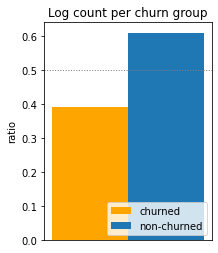

In [71]:
# Define f function and analyse it
f_LogCount = data \
    .groupby('userId', 'churn') \
    .agg(count('userId').alias('f-value'))

# Get g function
g = get_g(f_LogCount)

analyse(g, None, title='Log count per churn group', loc=4, width=3, height=4);

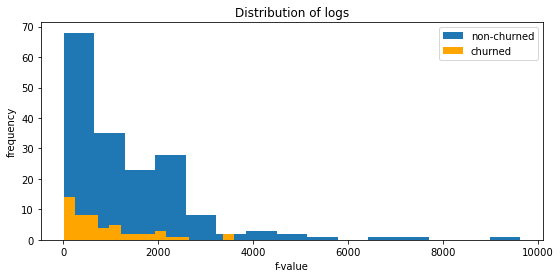

In [72]:
# Show distribution of f-values
plot_hist(f_LogCount, None, 'Distribution of logs', width=9, height=4)

##### Log attribute count
> - The feature function $f$ returns the **log attribute count** per user. 
> - The group function $g$ return the **average log attribute count** per churn group.

In [74]:
def get_f_LogAttributeCount(data, attribute):
    """Returns the feature function for log attribute count statistics.
    
    Args:
        data (DataFrame): The data set.
        attribute (str): The attribute column name.
    """
    return data \
        .groupby('userId', 'churn', col(attribute).alias('attribute')) \
        .agg(count(attribute).alias('f-value'))

##### gender

+-----+---------+-----------+--------+---------+---------+
|churn|attribute|g-value    |ratio   |delta    |candidate|
+-----+---------+-----------+--------+---------+---------+
|1    |F        |958.4      |0.372857|-0.254286|true     |
|0    |F        |1612.02381 |0.627143|-0.254286|true     |
|1    |M        |803.0      |0.422015|-0.15597 |false    |
|0    |M        |1099.775281|0.577985|-0.15597 |false    |
+-----+---------+-----------+--------+---------+---------+



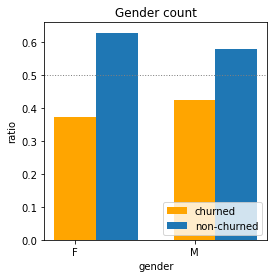

In [75]:
# Get f function by attribute and analyse it
f_GenderCount = get_f_LogAttributeCount(data, 'gender')

# Get g function
g = get_g(f_GenderCount)

# Define attribute
attr_dict = get_attribute(data, 'gender')

analyse(g, attr_dict=attr_dict, title='Gender count', loc=4, width=4, height=4);

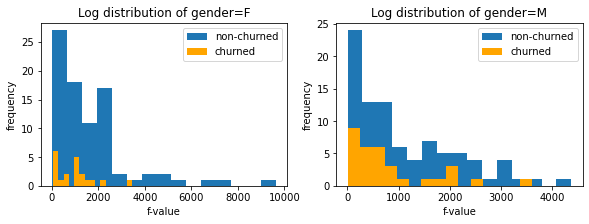

In [76]:
# Show distribution of f-values
plot_hist(f_GenderCount, attr_dict, 'Distribution of logs')

##### method

+-----+---------+-----------+--------+---------+---------+
|churn|attribute|g-value    |ratio   |delta    |candidate|
+-----+---------+-----------+--------+---------+---------+
|1    |GET      |71.865385  |0.426827|-0.146346|false    |
|0    |GET      |96.505814  |0.573173|-0.146346|false    |
|1    |PUT      |790.903846 |0.387043|-0.225914|true     |
|0    |PUT      |1252.549133|0.612957|-0.225914|true     |
+-----+---------+-----------+--------+---------+---------+



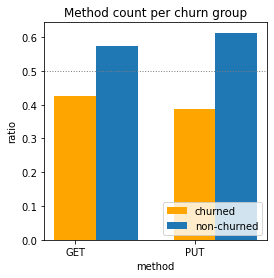

In [77]:
# Get f function by attribute and analyse it
f_MethodCount = get_f_LogAttributeCount(data, 'method')

# Get g function
g = get_g(f_MethodCount)

# Define attribute
attr_dict = get_attribute(data, 'method')

analyse(g, attr_dict=attr_dict, title='Method count per churn group', loc=4, width=4, height=4);

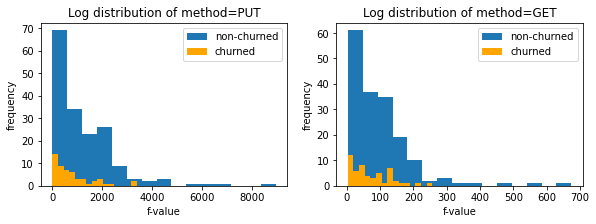

In [78]:
# Show distribution of f-values
plot_hist(f_MethodCount, attr_dict, 'Distribution of method logs', 'method')

##### status

+-----+---------+-----------+--------+---------+---------+
|churn|attribute|g-value    |ratio   |delta    |candidate|
+-----+---------+-----------+--------+---------+---------+
|1    |200      |791.096154 |0.390536|-0.218928|true     |
|0    |200      |1234.572254|0.609464|-0.218928|true     |
|1    |307      |71.057692  |0.384037|-0.231927|true     |
|0    |307      |113.97076  |0.615963|-0.231927|true     |
|1    |404      |1.454545   |0.385787|-0.228426|true     |
|0    |404      |2.315789   |0.614213|-0.228426|true     |
+-----+---------+-----------+--------+---------+---------+



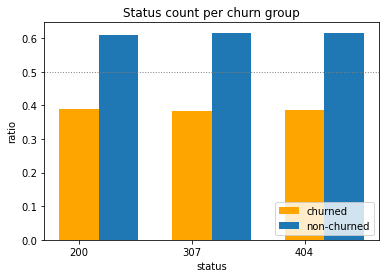

In [79]:
# Get f function by attribute and analyse it
f_StatusCount = get_f_LogAttributeCount(data, 'status')

# Get g function
g = get_g(f_StatusCount)

# Define attribute
attr_dict = get_attribute(data, 'status')

analyse(g, attr_dict=attr_dict, title='Status count per churn group', loc=4, width=6, height=4);

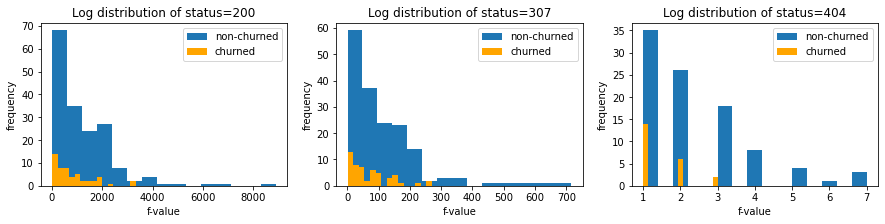

In [80]:
# Show distribution of f-values
plot_hist(f_StatusCount, attr_dict, 'Distribution of status logs', bins=15, width=15, height=3)

### User level

In [81]:
# Get churn group count
count1 = get_users(1).count()
count0 = get_users(0).count()
count1, count0

(52, 173)

In [83]:
def get_f_UserAttribute(data, attribute):
    """Returns the feature function of a user attribute.
    
    Args:
        data (DataFrame): The data set.
        attribute (str): The attribute column name.
    """
    return data \
        .select('userId', 'churn', col(attribute).alias('attribute')) \
        .dropDuplicates() \
        .withColumn('f-value', lit(1)) # the user attribute has f-value of 1 (counts as 1)

def get_g_UserAttribute(f, attribute):
    """Returns the group function of a user attribute.
    
    Args:
        data (DataFrame): The data set.
        attribute (str): The attribute column name.
    """
    return f \
        .withColumn('total', when(col('churn') == 1, count1).otherwise(count0)) \
        .groupby('churn', 'total', 'attribute') \
        .agg(Fsum('f-value')/col('total')) \
        .select('churn', 'total', 'attribute', col('(sum(f-value) / total)').alias('g-value')) \
        .sort('attribute', desc('churn'))

##### gender
> - The feature function $f$ returns the **f-value of 1 per user**.
> - The group function $g$ returns the **gender ratio per churn**. 

+-----+---------+--------+--------+---------+---------+
|churn|attribute|g-value |ratio   |delta    |candidate|
+-----+---------+--------+--------+---------+---------+
|1    |F        |0.384615|0.442003|-0.115994|false    |
|0    |F        |0.485549|0.557997|-0.115994|false    |
|1    |M        |0.615385|0.544667|0.089335 |false    |
|0    |M        |0.514451|0.455333|0.089335 |false    |
+-----+---------+--------+--------+---------+---------+



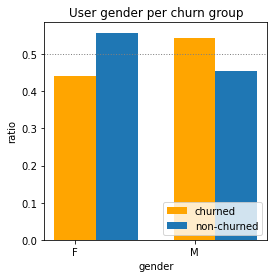

In [84]:
# Get f function
f_UserGender = get_f_UserAttribute(data, 'gender')

# Get g function
g_UserGender = get_g_UserAttribute(f_UserGender, 'gender')

# Define attribute
attr_dict = get_attribute(data, 'gender')

analyse(g_UserGender, attr_dict=attr_dict, title='User gender per churn group', loc=4, width=4, height=4);

##### Last level
> - The feature function $f$ returns the **f-value of 1 per user**.
> - The group function $g$ returns the **last level ratio per churn**.

+-----+---------+--------+--------+--------+---------+
|churn|attribute|g-value |ratio   |delta   |candidate|
+-----+---------+--------+--------+--------+---------+
|1    |free     |0.403846|0.542158|0.084316|false    |
|0    |free     |0.34104 |0.457842|0.084316|false    |
|1    |paid     |0.596154|0.47498 |-0.05004|false    |
|0    |paid     |0.65896 |0.52502 |-0.05004|false    |
+-----+---------+--------+--------+--------+---------+



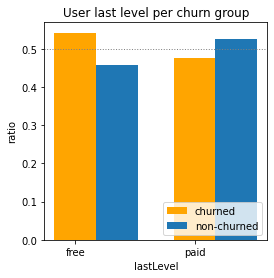

In [85]:
# Get f function
f_UserLastLevel = get_f_UserAttribute(data, 'lastLevel')

# Get g function
g_UserLastLevel = get_g_UserAttribute(f_UserLastLevel, 'lastLevel')

# Define attribute
attr_dict = get_attribute(data, 'lastLevel')

analyse(g_UserLastLevel, attr_dict=attr_dict, title='User last level per churn group', loc=4, width=4, height=4);

##### level per day

The subscription level (*free*, *paid*) is **user-time** dependent. It belongs to a user and the user can change it in time.

*Helper functions:*

In [87]:
def convert_to_date(date_str):
    """Converts date string to date object.
    
    Args:
        date_str (str): The date string in format YYYY-mm-dd.
        
    Returns:
        datetime: The datetime object.
    """
    return datetime.datetime.strptime(date_str, '%Y-%m-%d').date()

def get_date_str(month, day):
    """Gets date string from month and day parameter. 
    Note: The default observation year 2018 is used.
    
    Args:
        month (int): The month value.
        day (int): The day value.
        
    Returns:
        str: The date string.
    """
    return '2018-' + str(month).zfill(2) + '-' + str(day).zfill(2)

def get_date(month, day):
    """Gets date object.
    
    Args:
        month (int): The month value.
        day (int): The day value.
        
    Returns:
        date: The date object.
    """
    try:
        date_str = get_date_str(month, day)
        return datetime.datetime.strptime(date_str, '%Y-%m-%d').date()
    except ValueError:
        return None   

def validate_date(month, day):
    """Validates the date.
    
    Args:
        month (int): The month value.
        day (int): The day value.
        
    Returns:
        bool: True, if the date string built of month, day parameters is a valid date; else false.
    """
    try:
        date_str = get_date_str(month, day)
        datetime.datetime.strptime(date_str, '%Y-%m-%d')
        return True
    except ValueError:
        return False   
    
def get_dates_gen(date1, date2):
    """Gets date generator that returns (month, day) tuple between date1 and date2. 
    
    Args:
        date1 (date): The date1 value.
        date1 (date): The date2 value.
        
    Returns:
        date: Fetches the next date value.
    """    
    for m in range(date1.month, date2.month+1):
        for d in range(1, 31+1):
            date = get_date(m, d)
            if date == None or date <= date1 or date >= date2:
                continue                      
            yield date    

def get_ut_row(userId, date, level):
    """Gets user per time matrix row.
    
    Args:
        userId (str): The userId value.
        date (date): The date value.
        level (str): The level value.
        
    Returns:
        object: The object with userId, date, and level values.
    """        
    return {
        'userId': userId,
        'date': date,
        'level': level
    }

def get_default_date():
    """
    Gets the date from the beginning of the observation period.
    """          
    return datetime.datetime.strptime('2018-09-30', '%Y-%m-%d').date()


*Extract user-time distinct rows with level value:*

In [88]:
extracted = data \
    .groupby('userId', 'date') \
    .agg(max('userRowId').alias('rowid')) \
    .select(col('userId').alias('uid'), 'date', 'rowid')
    
# Note: if a user has more than 1 different level per day, then we take the last level
user_time_rows = extracted \
    .join(data, (extracted.uid == data.userId) & (extracted.rowid == data.userRowId), how='inner') \
    .select(data.userId, extracted.date, data.level) \
    .sort('userId', 'date') \
    .collect()

*Add missing user-time rows:*

In [89]:
# Observation period
data.agg(min('date'), max('date')).show()

+----------+----------+
| min(date)| max(date)|
+----------+----------+
|2018-10-01|2018-12-03|
+----------+----------+



In [93]:
# Build the user-time dimension matrix for the whole observation period from Oct 1, 2018 to Dec 3, 2018.
# Important: if in time t2 the user has no user_time row, then it holds:
#    level(user, t2) = level(user, t1)

# User set
users = {row.userId for row in user_time_rows}

# User-time dimension matrix
ut_matrix = []

# Current user-time level - fill it with default (None) values 
current_levels = dict()
for userId in users:
    current_levels[userId] = None

# Convert user_time rows into pandas dataframe (for easier filtering)
utdf = pd.DataFrame(user_time_rows)
utdf.columns = ['userId', 'date', 'level']

# Current dimension variables - defaults are set on Sept 30
last_userId, last_date = '-1', get_default_date()

# Loop through the user-time rows sorted by userId, month, day
for row in user_time_rows:
    
    userId = row.userId
    
    # Reset last date when user changes
    if userId != last_userId:
        last_date = get_default_date()
    
    # Get current user level
    last_level = current_levels[userId]
    
    # Add missing dimensions (up till current row date)
    #   level := last_level
    # Note: we skip None levels that represent missing logs before the first user log.
    if last_level != None:
        for date in get_dates_gen(last_date, row.date):
            ut_matrix.append(get_ut_row(userId, date, last_level))
        
    # Add level for current row date
    ut_matrix.append(get_ut_row(userId, row.date, row.level))
       
    # Handle history variables
    last_date = row.date       
    last_userId = userId
    current_levels[userId] = row.level

*Calculate the level ratio per churn group, for each day in the observation period:*

In [94]:
# Prepare churn data
churn_df = data.select('userId', 'churn').dropDuplicates().toPandas()

# Convert user_time matrix to pandas framework
ut_df = pd.DataFrame(ut_matrix)
ut_df = ut_df[['userId', 'date', 'level']]

# Add churn indicator
ut_df = ut_df.merge(churn_df, on='userId')

In [95]:
# Prepare agg totals per day and churn group
level_totals_df = ut_df \
    .groupby(['churn', 'date']) \
    .size() \
    .reset_index(name='count') \
    .rename(columns={'count': 'total'})

# Create level share dataframe
level_ratio_df = ut_df \
    .groupby(['churn', 'date', 'level']) \
    .size() \
    .reset_index(name='count') \
    .merge(level_totals_df, on=['churn', 'date'])
    
# Calc ratio
level_ratio_df['ratio'] = level_ratio_df['count']/level_ratio_df['total']

*Plot total count of level category per day:*

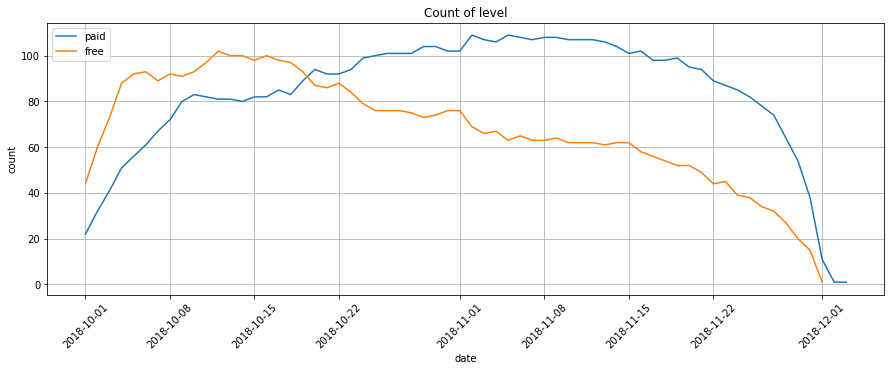

In [96]:
# Prepare agg totals per day and churn group
level_count_df = ut_df \
    .groupby(['level', 'date']) \
    .size() \
    .reset_index(name='count') \
    .sort_values(by=['date'])

# Plot
paid = level_count_df[level_count_df.level == 'paid']['count']
free = level_count_df[level_count_df.level == 'free']['count']
dates_paid = level_count_df[level_count_df.level == 'paid']['date']
dates_free = level_count_df[level_count_df.level == 'free']['date']

fig, ax = plt.subplots()
fig.set_size_inches(15, 5)

ax.plot(dates_paid, paid)
ax.plot(dates_free, free)

ax.set(xlabel='date', ylabel='count', title='Count of level')
ax.grid()
plt.legend(['paid', 'free'], loc=2)
plt.xticks(rotation = 45);
plt.show()

*Plot level ratio per churn group per day:*

In [290]:
def plot_level_ratio(df, level):
    """Plots level ratio along day timeline.
    
    Args:
        df (pandas DataFrame): The data set.
        level (str): The level value.
        
    Returns:
        None
    """
    df_ratio = df[(df.level == level)]

    ratios0 = df_ratio[df_ratio.churn == 0]['ratio']
    ratios1 = df_ratio[df_ratio.churn == 1]['ratio']
    dates0 = df_ratio[df_ratio.churn == 0]['date']
    dates1 = df_ratio[df_ratio.churn == 1]['date']

    fig, ax = plt.subplots()
    fig.set_size_inches(15, 5)

    # plot both lines
    ax.plot(dates0, ratios0)
    ax.plot(dates1, ratios1)

    ax.set(xlabel='date', ylabel='ratio', title="Ratio of level='" + level + "'")
    ax.grid()
    plt.legend(['non-churned', 'churned'], loc=2)
    plt.xticks(rotation = 45);
    plt.show()

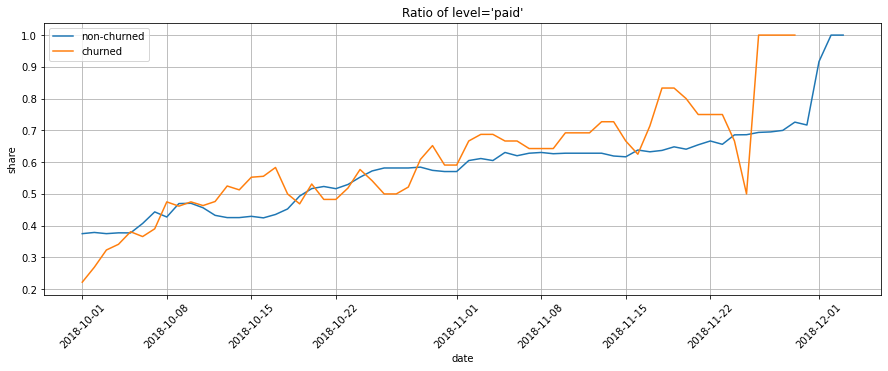

In [98]:
plot_level_ratio(level_ratio_df, 'paid')

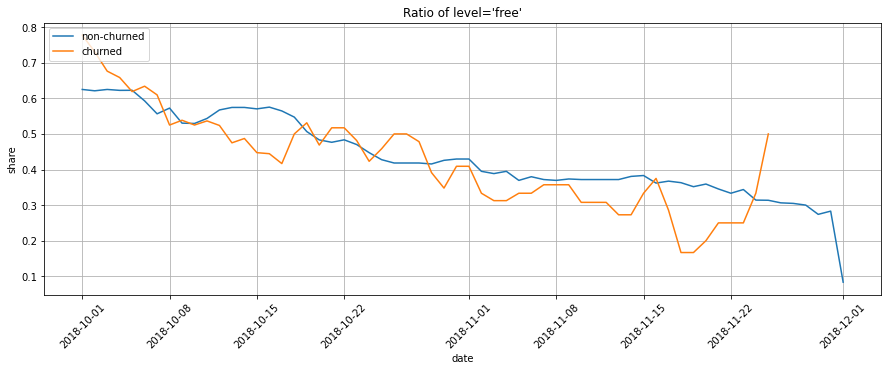

In [99]:
plot_level_ratio(level_ratio_df, 'free')

### Song level

##### Song count
> - The feature function $f$ returns the **song count per user**.
> - The group function $g$ returns the **average song count per churn**.

+-----+----------+--------+---------+---------+
|churn|g-value   |ratio   |delta    |candidate|
+-----+----------+--------+---------+---------+
|1    |699.884615|0.387092|-0.225816|true     |
|0    |1108.17341|0.612908|-0.225816|true     |
+-----+----------+--------+---------+---------+



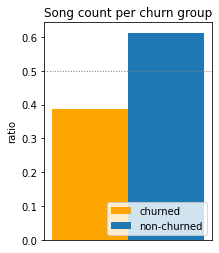

In [100]:
# Define f function - we are using the same function f that was used for the NextSong log page attribute. 
f_SongCount = get_f_LogAttributeCount(data, 'page') \
    .where(col('attribute') == 'NextSong') \
    .select('userId', 'churn', 'f-value')

g_SongCount = get_g(f_SongCount)

analyse(g_SongCount, None, title='Song count per churn group', loc=4, width=3, height=4);

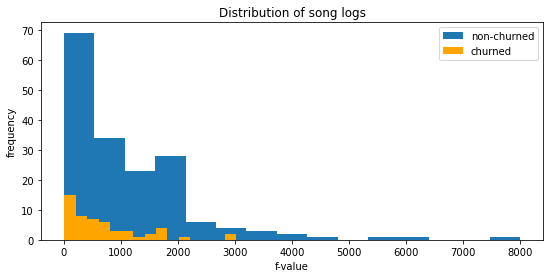

In [101]:
# Show distribution of f-values
plot_hist(f_SongCount, None, 'Distribution of song logs', bins=15, width=9, height=4)

In [102]:
def plot_timeline(g, title, timeunit, rotation=0):
    """Plots statistical values on a timeline of a specified time unit.
    
    Args:
        g (DataFrame): The group function.
        title (str): The plot's title.
        timeunit (str): The time unit of a timeline.
        rotation (int, optional): The label rotation of the plot's legend. 
    """
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 4)

    # convert g result set to pandas DataFrame and split it by churn
    df = g.toPandas()
    df0 = df[df.churn == 0]
    df1 = df[df.churn == 1]
    
    ax.plot(df0['attribute'], df0['g-value'])
    ax.plot(df1['attribute'], df1['g-value'])
    ax.set(xlabel=timeunit, ylabel='g-value', title=title)
    ax.grid()
    plt.legend(['non-churned', 'churned'], loc=2)
    plt.xticks(rotation = rotation);
    plt.show()

##### "Plain" song count per day

Let us examine first the aggregation result of the **song count per day, per churn** using a "plain" $g$ function without the $f$ function. In other words, the aggregation is not made over the f-values (which are *user-based*) but by counting the observing *song* attribute directly over all members of the churn group. 

In [104]:
# Define the "plain" g function
g_SongCountPerDay_plain = data \
    .where(data.page == 'NextSong') \
    .groupby('churn', 'date') \
    .count() \
    .select('churn', col('date').alias('attribute'), col('count').alias('g-value')) \
    .sort('attribute')

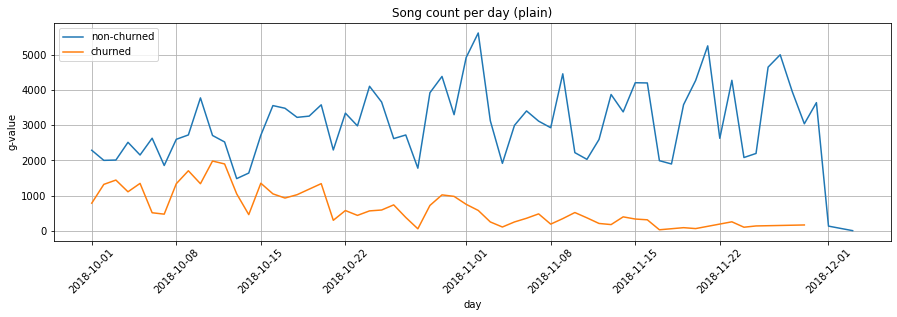

In [105]:
plot_timeline(g_SongCountPerDay_plain, 'Song count per day (plain)', 'day', 45)

##### Song count per day

Now we'll check the aggregation using the corresponding *user-based* $f$ function.

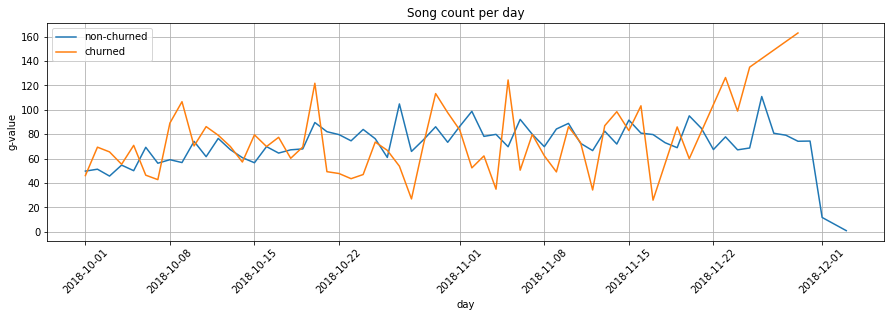

In [106]:
# Define f function
f_SongCountPerDay = data \
    .where(data.page == 'NextSong') \
    .groupby('userId', 'churn', col('date').alias('attribute')) \
    .agg(count('userId').alias('f-value'))

# Get g function
g_SongCountPerDay = get_g(f_SongCountPerDay)

# Plot it
plot_timeline(g_SongCountPerDay, 'Song count per day', 'day', 45)

While the **plain aggregation** shows substantial difference between the observed *g-values* of the both churn groups, the aggregation of the $f$ function reveals totally different picture: the *g-values* are not clearly separated, on the contrary, their lines swing crossing each other many times.

If we calculate the delta *over the whole observation period* it is even more clear the difference between the two types of aggregations we have made.   

In [107]:
g_plain = g_SongCountPerDay_plain \
    .groupby('churn') \
    .agg(Fsum('g-value').alias('g-value'))
deltaset = calc_delta(g_plain)
deltaset.show()

+-----+-------+-------------------+-------------------+---------+
|churn|g-value|              ratio|              delta|candidate|
+-----+-------+-------------------+-------------------+---------+
|    1|  36394|0.15954723201290616|-0.6809055359741877|     true|
|    0| 191714| 0.8404527679870938|-0.6809055359741876|     true|
+-----+-------+-------------------+-------------------+---------+



In [108]:
g = g_SongCountPerDay \
    .groupby('churn') \
    .agg(Fsum('g-value').alias('g-value'))
deltaset = calc_delta(g)
deltaset.show()

+-----+-----------------+------------------+--------------------+---------+
|churn|          g-value|             ratio|               delta|candidate|
+-----+-----------------+------------------+--------------------+---------+
|    1|3986.906254026817|0.4684556211944584|-0.06308875761108323|    false|
|    0|4523.838571408485|0.5315443788055416|-0.06308875761108323|    false|
+-----+-----------------+------------------+--------------------+---------+



Suppose that each user from both churn groups listen **1** song per day (*f-value*). In case of using the *user-based* $f$ function we calculate the churn average per day which would give us **1** at any date (since every user listens exactly **1** song per day). The graph would be a horizontal line since both lines would perfectly overlap. 

On the other side, the plain aggregation counts the total of song logs per each churn group. If there are 52 churned users and 173 non-churned, then the delta is

> $\Delta$ = $\frac{53-173}{225}$ = -0.54

which is close to **-0.68** of the plain aggregation. Matematically, we haven't *normalized* our observed values when we applied the plain aggregation. Since the weight of the *non-churned* group is higher due to having more members, this initial difference in weights between the both churn groups must be normalized by the proper preparation of *f-values* which is: 

> **The group function $g$ must always apply aggregation over the feature function $f$ which exposes f-values calculated *per user***. 

##### Song count per week of year

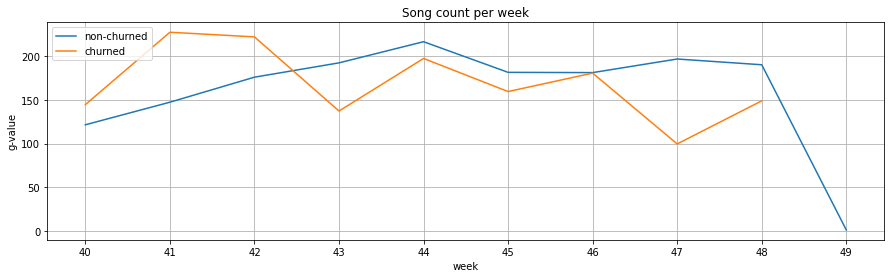

In [109]:
# Define f function
f_SongCountPerWeek = data \
    .withColumn('weekOfYear', date_format(col('tsDate'), "w")) \
    .where(data.page == 'NextSong') \
    .groupby('userId', 'churn', col('weekOfYear').alias('attribute')) \
    .agg(count('userId').alias('f-value'))

# Get g function
g_SongCountPerWeek = get_g(f_SongCountPerWeek)

# Plot it
plot_timeline(g_SongCountPerWeek, 'Song count per week', 'week')

In [110]:
# Delta over the whole observation period
g = g_SongCountPerWeek \
    .groupby('churn') \
    .agg(Fsum('g-value').alias('g-value'))
deltaset = calc_delta(g)
deltaset.show()

+-----+------------------+-------------------+--------------------+---------+
|churn|           g-value|              ratio|               delta|candidate|
+-----+------------------+-------------------+--------------------+---------+
|    1|  1518.65330509284|0.48605415017904274|-0.02789169964191...|    false|
|    0|1605.7996072697629| 0.5139458498209574|-0.02789169964191...|    false|
+-----+------------------+-------------------+--------------------+---------+



##### Song count per day of week

In [111]:
# Define f function
f_SongCountPerDayOfWeek = data \
    .withColumn('dayOfWeek', date_format(col('date'), 'E')) \
    .withColumn('dayOfWeekNum', date_format(col('date'), "u")) \
    .where(data.page == 'NextSong') \
    .groupby('userId', 'churn', 'dayOfWeekNum', 'dayOfWeek') \
    .agg(count('userId').alias('f-value'))

# Get g function
g_SongCountPerDayOfWeek = f_SongCountPerDayOfWeek \
    .groupby('churn', 'dayOfWeekNum', 'dayOfWeek') \
    .agg(avg('f-value').alias('g-value')) \
    .sort('dayOfWeekNum')

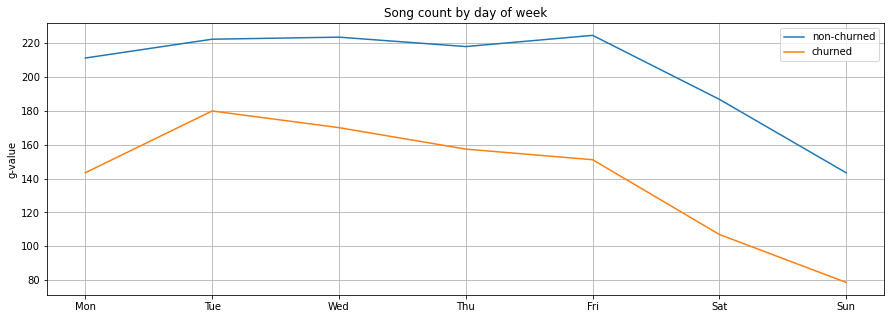

In [112]:
# Plot it
df = g_SongCountPerDayOfWeek.toPandas()
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)

# split by churn
df0 = df[df.churn == 0]
df1 = df[df.churn == 1]
ax.plot(df0['dayOfWeekNum'], df0['g-value'])
ax.plot(df1['dayOfWeekNum'], df1['g-value'])

labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax.set_xticklabels(labels)
ax.grid()
ax.set_ylabel('g-value')
ax.set_title('Song count by day of week')
plt.legend(['non-churned', 'churned'], loc=1)
plt.show()

In [113]:
# Delta over the whole observation period 
# We'll use a proper f function whose f-value represents an average of song count per day of week.
f = f_SongCountPerDayOfWeek \
    .groupby('userId', 'churn') \
    .agg(avg('f-value').alias('f-value'))

g = f.groupby('churn').agg(Fsum('f-value').alias('g-value'))

deltaset = calc_delta(g)
deltaset.show()

+-----+-----------------+-------------------+-------------------+---------+
|churn|          g-value|              ratio|              delta|candidate|
+-----+-----------------+-------------------+-------------------+---------+
|    1|6269.585714285715|0.16892325255778404|-0.6621534948844319|     true|
|    0|30845.40952380953| 0.8310767474422159|-0.6621534948844319|     true|
+-----+-----------------+-------------------+-------------------+---------+



This is now much better, the feature *Song count by day of week* shows a solid difference between the *g-values*.

##### Song count per hour of day
Counts song logs aggregated by hour of day.

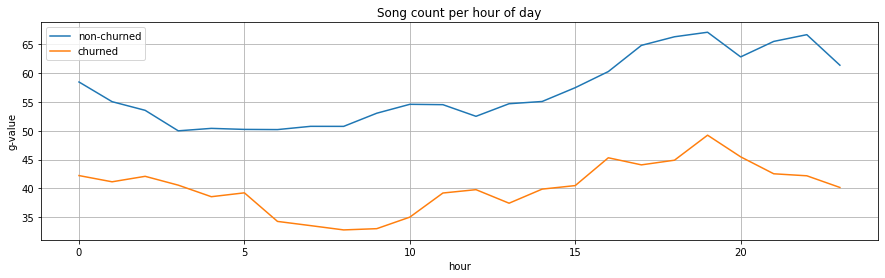

In [114]:
# Define f function
f_SongCountPerHourOfDay = data \
    .withColumn('hour', hour(col('tsDate'))) \
    .where(data.page == 'NextSong') \
    .groupby('userId', 'churn', col('hour').alias('attribute')) \
    .agg(count('userId').alias('f-value'))

# Get g function
g_SongCountPerHourOfDay = get_g(f_SongCountPerHourOfDay)

# Plot it
plot_timeline(g_SongCountPerHourOfDay, 'Song count per hour of day', 'hour')

In [115]:
# Delta over the whole observation period using a proper f function
f = f_SongCountPerHourOfDay \
    .groupby('userId', 'churn') \
    .agg(avg('f-value').alias('f-value'))

g = f.groupby('churn').agg(Fsum('f-value').alias('g-value'))

deltaset = calc_delta(g)
deltaset.show()

+-----+------------------+-------------------+-------------------+---------+
|churn|           g-value|              ratio|              delta|candidate|
+-----+------------------+-------------------+-------------------+---------+
|    1|1708.3008402703915|0.16839565991928815|-0.6632086801614236|     true|
|    0| 8436.264887190628| 0.8316043400807119|-0.6632086801614239|     true|
+-----+------------------+-------------------+-------------------+---------+



##### Total song length
Calculates the total length of all song events.

+-----+-------------+--------+---------+---------+
|churn|g-value      |ratio   |delta    |candidate|
+-----+-------------+--------+---------+---------+
|1    |174014.268551|0.386543|-0.226915|true     |
|0    |276166.937468|0.613457|-0.226915|true     |
+-----+-------------+--------+---------+---------+



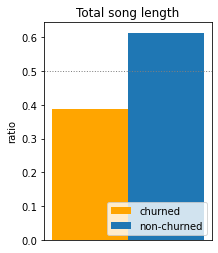

In [116]:
# Define f function
f_TotalSongLength = data \
    .where(data.page == 'NextSong') \
    .groupby('userId', 'churn') \
    .agg(Fsum('length').alias('f-value'))

# Get g function
g_TotalSongLength = get_g(f_TotalSongLength)

analyse(g_TotalSongLength, attr_dict=None, title='Total song length', loc=4, width=3, height=4);

##### Non-song count
Counts non-song page events.

+-----+----------+--------+---------+---------+
|churn|g-value   |ratio   |delta    |candidate|
+-----+----------+--------+---------+---------+
|1    |162.884615|0.402576|-0.194847|false    |
|0    |241.72093 |0.597424|-0.194847|false    |
+-----+----------+--------+---------+---------+



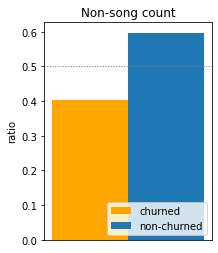

In [117]:
# Define f function
f_NonSongCount = data \
    .where(data.page != 'NextSong') \
    .groupby('userId', 'churn') \
    .agg(count('userId').alias('f-value'))

# Get g function
g_NonSongCount = get_g(f_NonSongCount)

analyse(g_NonSongCount, attr_dict=None, title='Non-song count', loc=4, width=3, height=4);

##### Unique song count
Counts unique songs.

+-----+----------+--------+---------+---------+
|churn|g-value   |ratio   |delta    |candidate|
+-----+----------+--------+---------+---------+
|1    |638.365385|0.395485|-0.209031|true     |
|0    |975.768786|0.604515|-0.209031|true     |
+-----+----------+--------+---------+---------+



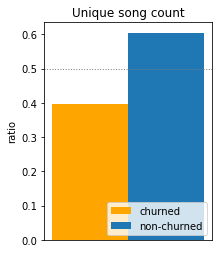

In [118]:
# Define f function
# Note: We use song column to identity the song.
f_UniqueSongCount = data \
    .where(data.page == 'NextSong') \
    .select('userId', 'churn', 'song') \
    .dropDuplicates() \
    .groupby('userId', 'churn') \
    .agg(count('userId').alias('f-value'))

# Get g function
g_UniqueSongCount = get_g(f_UniqueSongCount)

analyse(g_UniqueSongCount, attr_dict=None, title='Unique song count', loc=4, width=3, height=4);

### Session level

##### Session count

+-----+---------+--------+---------+---------+
|churn|g-value  |ratio   |delta    |candidate|
+-----+---------+--------+---------+---------+
|1    |10.326923|0.403691|-0.192618|false    |
|0    |15.254335|0.596309|-0.192618|false    |
+-----+---------+--------+---------+---------+



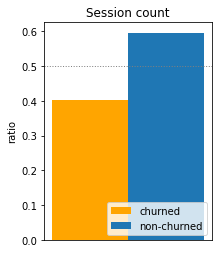

In [119]:
# Define f function
f_SessionCount = data \
    .select( 'userId', 'churn', 'sessionId') \
    .dropDuplicates() \
    .groupby('userId', 'churn') \
    .agg(count('userId').alias('f-value'))

# Get g function
g_SessionCount = get_g(f_SessionCount)

analyse(g_SessionCount, attr_dict=None, title='Session count', loc=4, width=3, height=4);

##### Session count per day

+-----+--------+--------+--------+---------+
|churn|g-value |ratio   |delta   |candidate|
+-----+--------+--------+--------+---------+
|1    |1.18664 |0.514494|0.028988|false    |
|0    |1.119783|0.485506|0.028988|false    |
+-----+--------+--------+--------+---------+



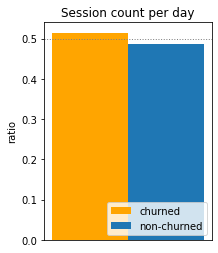

In [120]:
# Define f function
f_SessionCountPerDay = data \
    .select( 'userId', 'churn', 'sessionId', 'date') \
    .dropDuplicates() \
    .groupby('userId', 'churn', 'date') \
    .count() \
    .groupby('userId', 'churn') \
    .agg(avg('count').alias('f-value'))

# Get g function
g_SessionCountPerDay = get_g(f_SessionCountPerDay)

analyse(g_SessionCountPerDay, attr_dict=None, title='Session count per day', loc=4, width=3, height=4);

##### Average session duration

+-----+------------+-------+--------+---------+
|churn|g-value     |ratio  |delta   |candidate|
+-----+------------+-------+--------+---------+
|1    |15574.471817|0.46658|-0.06684|false    |
|0    |17805.596824|0.53342|-0.06684|false    |
+-----+------------+-------+--------+---------+



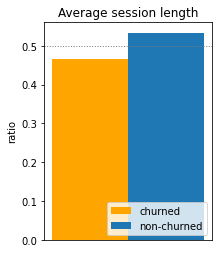

In [121]:
f_AvgSessionLength = data \
    .groupby('userId', 'churn', 'sessionId') \
    .agg(((max('ts') - min('ts'))/1000).alias('sessionLength')) \
    .groupby('userId', 'churn') \
    .agg(avg('sessionLength').alias('f-value'))

# Get g function
g_AvgSessionLength = get_g(f_AvgSessionLength)

analyse(g_AvgSessionLength, attr_dict=None, title='Average session length', loc=4, width=3, height=4);

##### Average session gap
A *session gap* is a gap of no user activity between the sessions.

We are using the following formula to calculate the average session gap per user:

> average session gap = $\frac{observationTime - sessionTime}{sessionCount - 1}$

The dividend is a **total session gap time** per user and the divisor is the **number of gaps** between the sessions per user which equals the total number of sessions decreased by 1 given that *n* sessions have *n $-$ 1* gaps.

+-----+--------------+--------+---------+---------+
|churn|g-value       |ratio   |delta    |candidate|
+-----+--------------+--------+---------+---------+
|1    |2276674.784306|0.348204|-0.303592|true     |
|0    |4261658.171781|0.651796|-0.303592|true     |
+-----+--------------+--------+---------+---------+



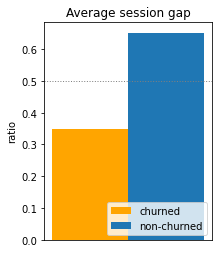

In [122]:
# Define f function
f_AvgSessionGap = data \
    .groupby('userId', 'churn', 'sessionId') \
    .agg(min('ts').alias('startTime'), max('ts').alias('endTime')) \
    .groupby('userId', 'churn') \
    .agg(count('userId').alias('sessionCount'), \
        ((max('endTime') - min('startTime'))/1000).alias('observationPeriodTime'), \
        (Fsum(col('endTime') - col('startTime'))/1000).alias('totalSessionTime')) \
    .where(col('sessionCount') > 1) \
    .select('userId', 'churn', \
            (col('observationPeriodTime') - col('totalSessionTime')/(col('sessionCount') - 1)).alias('f-value'))

# Get g function
g_AvgSessionGap = get_g(f_AvgSessionGap)

analyse(g_AvgSessionGap, attr_dict=None, title='Average session gap', loc=4, width=3, height=4);

It looks a promising feature!

### Page level

In [123]:
def filter_page(data, event):
    """Filter page logs by event.
    
    Args:
        data (DataFrame): The data set.
        event (str): The name of an event (or page attribute value).
    """
    return data.where(data.page == event)

*Remark on excluded events:*

We'll check the delta values for each page event except for the *Cancel*, *Cancellation Confirmation*, and *Submit Downgrade* events. The reason why we exclude the *Cancel* and *Cancellation Confirmation* event is that we use the latter to **define** our label - *it is a part of the label definition of cancelled users*, and since the *Cancel* event is its predecessor event we have to exclude it too. The *Submit Downgrade* event is used *to define the label of the downgraded users*. As we opt **not to mix the both churn types** - the *cancelled* and the *downgraded* users - we prefer not to use any feature that is part of the label definition of the other churn type. 



In [124]:
# Let's check if the predecessor of every Cancellation Confirmation event is the Cancel event 
# and if the predecessor of every Cancellation Confirmation event is the Cancel event.
print(f"Total of Cancel events: {filter_page(data, 'Cancel').count()}")
print(f"Total of Cancellation Confirmation events: {filter_page(data, 'Cancellation Confirmation').count()}")
cancelConfirmationLogs = data.where(data.page == 'Cancellation Confirmation').select(col('userRowId').alias('rowId'))
cancelWithConfirmationLogs = data.where(data.page == 'Cancel') \
    .join(cancelConfirmationLogs, cancelConfirmationLogs.rowId == data.userRowId + 1);
print(f'Total of Cancel -> Cancellation Confirmation events: {cancelWithConfirmationLogs.count()}')

Total of Cancel events: 52
Total of Cancellation Confirmation events: 52
Total of Cancel -> Cancellation Confirmation events: 52


In [125]:
# Exclude events that form part of the label definition (of both churn types)
page_data = data.where(~data.page.isin(['Cancel', 'Cancellation Confirmation', 'Submit Downgrade']))

##### page count

+-----+---------------+----------+--------+---------+---------+
|churn|attribute      |g-value   |ratio   |delta    |candidate|
+-----+---------------+----------+--------+---------+---------+
|1    |About          |1.806452  |0.337858|-0.324284|true     |
|0    |About          |3.540323  |0.662142|-0.324284|true     |
|1    |Add Friend     |14.454545 |0.391405|-0.217189|true     |
|0    |Add Friend     |22.475309 |0.608595|-0.217189|true     |
|1    |Add to Playlist|20.76     |0.384298|-0.231404|true     |
|0    |Add to Playlist|33.260606 |0.615702|-0.231404|true     |
|1    |Downgrade      |9.628571  |0.400098|-0.199804|false    |
|0    |Downgrade      |14.436975 |0.599902|-0.199804|false    |
|1    |Error          |1.454545  |0.385787|-0.228426|true     |
|0    |Error          |2.315789  |0.614213|-0.228426|true     |
|1    |Help           |5.55814   |0.405334|-0.189333|false    |
|0    |Help           |8.154362  |0.594666|-0.189333|false    |
|1    |Home           |32.784314 |0.4013

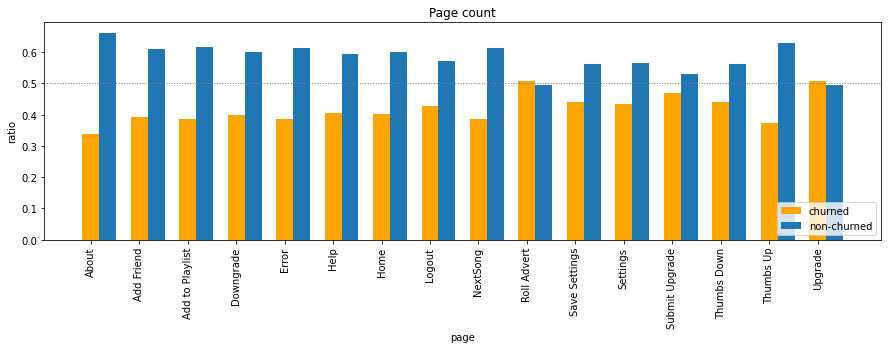

In [126]:
# Get f function by attribute and analyse it
f_PageCount = get_f_LogAttributeCount(page_data, 'page')

# Get g function
g = get_g(f_PageCount)

# Define attribute
attr_dict = get_attribute(page_data, 'page')

analyse(g, attr_dict=attr_dict, title='Page count', loc=4, width=15, height=4, rotation=90);

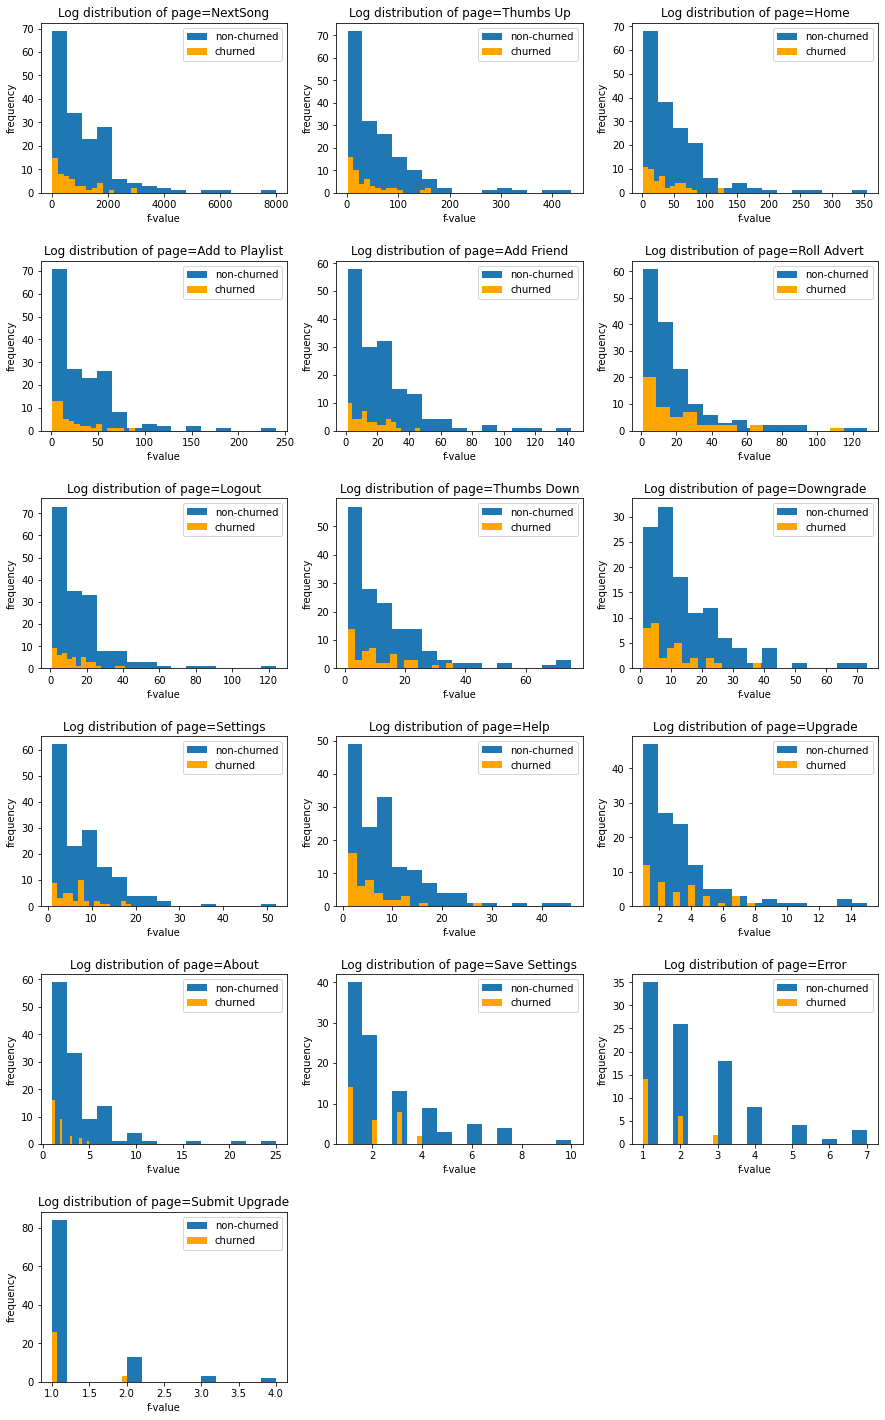

In [127]:
# Show distribution of f-values
plot_hist(f_PageCount, attr_dict, 'Distribution of page logs', bins=15, width=15, height=25)

##### page count per session hour
Counts page events per session hour.

+-----+---------------+---------+--------+---------+---------+
|churn|attribute      |g-value  |ratio   |delta    |candidate|
+-----+---------------+---------+--------+---------+---------+
|1    |About          |1.857849 |0.832283|0.664566 |true     |
|0    |About          |0.374383 |0.167717|0.664566 |true     |
|1    |Add Friend     |1.117357 |0.064878|-0.870245|true     |
|0    |Add Friend     |16.105203|0.935122|-0.870245|true     |
|1    |Add to Playlist|0.701903 |0.37598 |-0.24804 |true     |
|0    |Add to Playlist|1.16496  |0.62402 |-0.24804 |true     |
|1    |Downgrade      |0.601787 |0.354387|-0.291225|true     |
|0    |Downgrade      |1.096317 |0.645613|-0.291225|true     |
|1    |Error          |0.233763 |0.537165|0.07433  |false    |
|0    |Error          |0.201416 |0.462835|0.07433  |false    |
|1    |Help           |0.375415 |0.496872|-0.006256|false    |
|0    |Help           |0.380142 |0.503128|-0.006256|false    |
|1    |Home           |21.073688|0.549619|0.099238 |fal

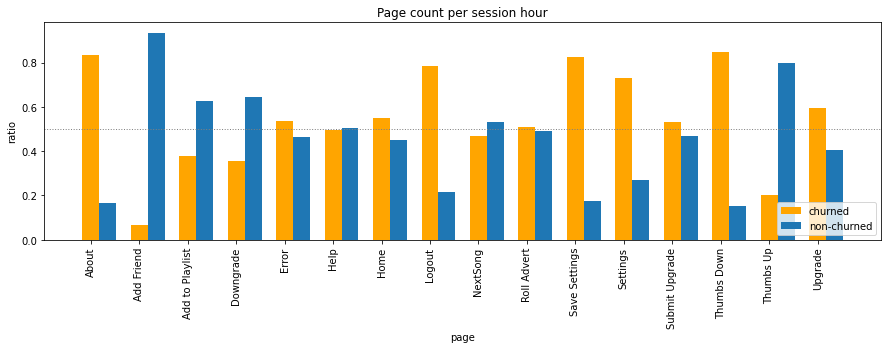

In [128]:
# Define session length (in hours)
sessionLength = data \
    .groupby('userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/1000/3600).alias('sessionLength'))

# Define f function
f_PageCountPerSessionHour = page_data \
    .join(sessionLength, on=['userId', 'sessionId'], how='inner') \
    .groupby('userId', 'churn', 'page', 'sessionId', 'sessionLength') \
    .agg((count('userId')/col('sessionLength')).alias('pageCountPerHour')) \
    .groupby('userId', 'churn', 'page') \
    .agg(avg('pageCountPerHour').alias('f-value')) \
    .select('userId', 'churn', col('page').alias('attribute'), 'f-value')

# Get g function
g = get_g(f_PageCountPerSessionHour)

# Define attribute
attr_dict = get_attribute(page_data, 'page')

analyse(g, attr_dict=attr_dict, \
        title='Page count per session hour', loc=4, width=15, height=4, rotation=90);

##### page count per hour
Counts page events per hour (of all sessions).

+-----+---------------+---------+--------+---------+---------+
|churn|attribute      |g-value  |ratio   |delta    |candidate|
+-----+---------------+---------+--------+---------+---------+
|1    |About          |0.038636 |0.468509|-0.062982|false    |
|0    |About          |0.04383  |0.531491|-0.062982|false    |
|1    |Add Friend     |0.358796 |0.516598|0.033196 |false    |
|0    |Add Friend     |0.33574  |0.483402|0.033196 |false    |
|1    |Add to Playlist|0.468369 |0.530474|0.060948 |false    |
|0    |Add to Playlist|0.414556 |0.469526|0.060948 |false    |
|1    |Downgrade      |0.156238 |0.536433|0.072865 |false    |
|0    |Downgrade      |0.135016 |0.463567|0.072865 |false    |
|1    |Error          |0.032598 |0.493312|-0.013375|false    |
|0    |Error          |0.033482 |0.506688|-0.013375|false    |
|1    |Help           |0.107449 |0.488919|-0.022161|false    |
|0    |Help           |0.112319 |0.511081|-0.022161|false    |
|1    |Home           |0.903384 |0.542083|0.084166 |fal

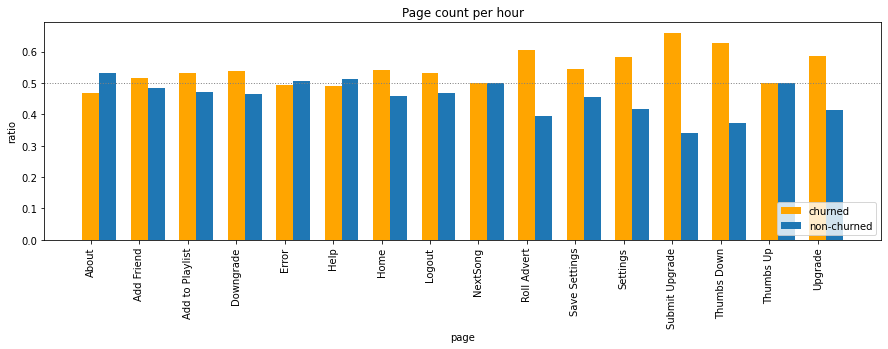

In [129]:
# Define total session length (in hours)
totalSessionLength = sessionLength \
    .groupby('userId') \
    .agg(Fsum('sessionLength').alias('totalSessionLength'))

# Define f function
f_PageCountPerHour = page_data \
    .join(totalSessionLength, 'userId', 'inner') \
    .groupby('userId', 'churn', 'page', 'totalSessionLength') \
    .agg((count('userId')/col('totalSessionLength')).alias('f-value')) \
    .select('userId', 'churn', col('page').alias('attribute'), 'f-value')

# Get g function
g = get_g(f_PageCountPerHour)

# Define attribute
attr_dict = get_attribute(page_data, 'page')

analyse(g, attr_dict=attr_dict, \
        title='Page count per hour', loc=4, width=15, height=4, rotation=90);

##### page count per day

+-----+---------------+---------+--------+---------+---------+
|churn|attribute      |g-value  |ratio   |delta    |candidate|
+-----+---------------+---------+--------+---------+---------+
|1    |About          |1.099462 |0.485785|-0.02843 |false    |
|0    |About          |1.163808 |0.514215|-0.02843 |false    |
|1    |Add Friend     |2.538865 |0.478921|-0.042157|false    |
|0    |Add Friend     |2.76235  |0.521079|-0.042157|false    |
|1    |Add to Playlist|2.683168 |0.488148|-0.023705|false    |
|0    |Add to Playlist|2.813463 |0.511852|-0.023705|false    |
|1    |Downgrade      |1.98826  |0.504785|0.009571 |false    |
|0    |Downgrade      |1.950562 |0.495215|0.009571 |false    |
|1    |Error          |1.068182 |0.492583|-0.014834|false    |
|0    |Error          |1.100351 |0.507417|-0.014834|false    |
|1    |Help           |1.351347 |0.483955|-0.032091|false    |
|0    |Help           |1.440955 |0.516045|-0.032091|false    |
|1    |Home           |3.433441 |0.50631 |0.012619 |fal

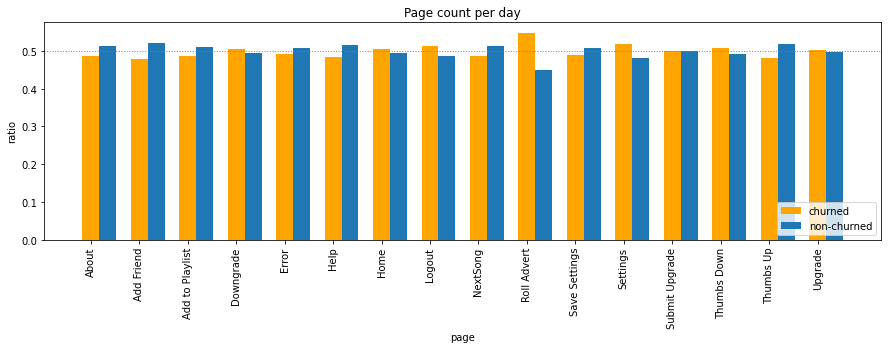

In [130]:
# Define f function
f_PageCountPerDay = page_data \
    .groupby('userId', 'churn', 'page', 'date') \
    .count() \
    .groupby('userId', 'churn', 'page') \
    .agg(avg('count').alias('f-value')) \
    .select('userId', 'churn', col('page').alias('attribute'), 'f-value')

# Get g function
g = get_g(f_PageCountPerDay)

# Define attribute
attr_dict = get_attribute(page_data, 'page')

analyse(g, attr_dict=attr_dict, \
        title='Page count per day', loc=4, width=15, height=4, rotation=90);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Remark on feature selection

You might notice below that some features that were marked as **candidate features** in the exploratory data analysis *do not appear in the final selection list* while some features that did not fulfill the delta threshold condition are listed here. The final decision about the feature selection was a combination of analytical insights, preliminary tests, and intuition.

### User attribute features

> - *Gender*
> - *Last level*

In [131]:
f_Gender = data \
    .select('userId', 'gender') \
    .dropDuplicates() \
    .replace(['M', 'F'], ['0', '1'], 'gender') \
    .select('userId', col('gender').cast('int').alias('Gender'))

f_LastLevel = data \
    .select('userId', 'lastLevel') \
    .dropDuplicates() \
    .replace(['free', 'paid'], ['0', '1'], 'lastLevel') \
    .select('userId', col('lastLevel').cast('int').alias('LastLevel'))

### Log features 

> - *Log count*

In [132]:
# Log count
f_LogCount = data \
    .groupby('userId') \
    .agg(count('userId').alias('LogCount'))

##### Page count: 
> - *About*
> - *Thumbs Up*
> - *Roll Advert*
> - *Add Friend*
> - *Add to Playlist*
> - *Downgrade*
> - *Error*
> - *Home*

In [133]:
def pageCount(page):
    """Returns the log count query filtered by a specified page."""
    return data \
        .where(data.page == page) \
        .groupby('userId') \
        .agg(count('userId').alias('count')) \
        .select('userId', col('count').alias(page.replace(' ', '') + 'Count'))

f_AboutCount = pageCount('About')
f_ThumbsUpCount = pageCount('Thumbs Up')
f_RollAdvertCount = pageCount('Roll Advert')
f_AddFriendCount = pageCount('Add Friend')
f_AddToPlaylistCount = pageCount('Add to Playlist')
f_DowngradeCount = pageCount('Downgrade')
f_ErrorCount = pageCount('Error')
f_HomeCount = pageCount('Home')

##### Page count per hour:
> - *Roll Advert*
> - *Thumbs Down*
> - *Upgrade*
> - *Submit Upgrade*

In [173]:
# Average page count per hour
periodHours = data \
    .groupby('userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/1000/3600).alias('periodHours')) \
    .groupby('userId') \
    .agg(Fsum('periodHours').alias('periodHours'))

def pageCountPerHour(page):
    """Returns log count per total observation period hour filtered by a specified page."""
    return data \
        .where(data.page == page) \
        .join(periodHours, 'userId', 'inner') \
        .groupby('userId', 'periodHours') \
        .agg((count('userId')/col('periodHours')).alias('avgPerHour')) \
        .select('userId', col('avgPerHour').alias(page.replace(' ', '') + 'PerHour'))

f_RollAdvertPerHour = pageCountPerHour('Roll Advert')
f_ThumbsDownPerHour = pageCountPerHour('Thumbs Down')
f_UpgradePerHour = pageCountPerHour('Upgrade')
f_SubmitUpgradePerHour = pageCountPerHour('Submit Upgrade')
f_LogoutPerHour = pageCountPerHour('Logout')

##### Page count per session hour:
> - *Error*
> - *Settings*
> - *Save Settings*
> - *Logout*
> - *Downgrade*

In [137]:
# Average page count per session hour
sessionHours = data \
    .groupby('userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/1000/3600).alias('sessionHours'))

def pageCountPerSessionHour(page):
    """Returns the log count per session hour filtered by a specified page."""
    return data \
        .where(data.page == page) \
        .join(sessionHours, ['userId', 'sessionId'], 'inner') \
        .groupby( 'userId', 'sessionId', 'sessionHours') \
        .agg((count('userId')/col('sessionHours')).alias('avgPerSessionHour')) \
        .groupby('userId') \
        .agg(avg('avgPerSessionHour').alias('avgPerSessionHour')) \
        .select('userId', col('avgPerSessionHour').alias(page.replace(' ', '') + 'PerSessionHour'))

f_ErrorPerSessionHour = pageCountPerSessionHour('Error')
f_SettingsPerSessionHour = pageCountPerSessionHour('Settings')
f_SaveSettingsPerSessionHour = pageCountPerSessionHour('Save Settings')
f_LogoutPerSessionHour = pageCountPerSessionHour('Logout')
f_DowngradePerSessionHour = pageCountPerSessionHour('Downgrade')

# We include Submit Downgrade event used in one exercise
# In such an extended project it is difficult to be perfectly consistent!
f_SubmitDowngradePerSessionHour = pageCountPerSessionHour('Submit Downgrade')

##### Page count per day:
> - *Add Friend*
> - *Roll Advert*
> - *Thumbs Down*
> - *Thumbs Up*

In [138]:
def pagePerDay(page):
    return data \
        .where(data.page == page) \
        .groupby('userId', 'date') \
        .count() \
        .groupby('userId') \
        .agg(avg('count').alias(page.replace(' ', '') + 'PerDay'))

f_AddFriendPerDay = pagePerDay('Add Friend')
f_RollAdvertPerDay = pagePerDay('Roll Advert')
f_ThumbsDownPerDay = pagePerDay('Thumbs Down')
f_ThumbsUpPerDay = pagePerDay('Thumbs Up')

##### Method count:
> - *PUT*

In [139]:
# Method PUT count
f_MethodPutCount = data \
    .where(data.method == 'PUT') \
    .groupby('userId') \
    .agg(count('userId').alias('MethodPutCount'))

##### Status count:
> - *200*
> - *307*
> - *404*

In [140]:
def statusCount(status):
    """Returns log count query filtered by a specified status."""
    return data \
        .where(data.status == status) \
        .groupby('userId') \
        .agg(count('userId').alias('Status' + str(status) + 'Count'))

f_Status200Count = statusCount(200)
f_Status307Count = statusCount(307)
f_Status404Count = statusCount(404)

### Session features
> - *Session count*
> - *Session count per day*
> - *Average session length*
> - *Average session gap*

In [141]:
# Total session count
f_SessionCount = data \
    .select('userId', 'sessionId') \
    .dropDuplicates() \
    .groupby('userId') \
    .agg(count('userId').alias('SessionCount'))

# Average session count per day
f_SessionsPerDay = data \
    .select('userId', 'date', 'sessionId') \
    .dropDuplicates() \
    .groupby('userId', 'date') \
    .count() \
    .groupby('userId') \
    .agg(avg('count').alias('SessionsPerDay'))

# Average session length
f_AvgSessionLength = data \
    .groupby('userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/1000).alias('sessionLength')) \
    .groupby('userId') \
    .agg(avg('sessionLength').alias('AvgSessionLength'))

# Average session gap
f_AvgSessionGap = data \
    .groupby('userId', 'sessionId') \
    .agg(min('ts').alias('startTime'), max('ts').alias('endTime')) \
    .groupby('userId') \
    .agg(count('userId').alias('sessionCount'), \
        ((max('endTime') - min('startTime'))/1000).alias('observationPeriodTime'), \
        (Fsum(col('endTime') - col('startTime'))/1000).alias('totalSessionTime')) \
    .where(col('sessionCount') > 1) \
    .join(data.select('userId').dropDuplicates(), 'userId', 'outer') \
    .fillna(0) \
    .select('userId', \
            (col('observationPeriodTime') - col('totalSessionTime')/(col('sessionCount') - 1)).alias('AvgSessionGap'))

### Song features
> - *Song count*
> - *Non-song count*
> - *Total song length*
> - *Unique song count*
> - *Unique song share*

In [142]:
# Song event count
f_SongCount = data \
    .where(data.page == 'NextSong') \
    .groupby('userId') \
    .agg(count('userId').alias('SongCount'))

# Song count per day
f_SongCountPerDay = data \
    .where(data.page == 'NextSong') \
    .groupby('userId') \
    .agg(count('userId').alias('SongCount'))

# Non-song event count
f_NonSongCount = data \
    .where(data.page != 'NextSong') \
    .groupby('userId') \
    .agg(count('userId').alias('NonSongCount'))

# All song total length  
f_TotalSongLength = data \
    .where(data.page == 'NextSong') \
    .select('userId', 'length') \
    .groupby('userId') \
    .agg(Fsum('length').alias('TotalSongLength'))

# Unique song event count
f_UniqueSongCount = data \
    .where(data.page == 'NextSong') \
    .select('userId', 'song') \
    .dropDuplicates() \
    .groupby('userId') \
    .agg(count('userId').alias('UniqueSongCount'))

# Share of unique song events among all song events
totals = data \
    .where(data.page == 'NextSong') \
    .select('userId') \
    .groupby('userId') \
    .agg(count('userId').alias('total'))

f_UniqueSongShare = data \
    .where(data.page == 'NextSong') \
    .select('userId', 'song') \
    .dropDuplicates() \
    .groupby('userId') \
    .count() \
    .join(totals, on = ['userId'], how = 'inner') \
    .select('userId', (col('count')/col('total')).alias('UniqueSongShare')) 

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

The *modeling part* of the project has been performed during an extended period of time (over several weeks). On several occasions the following machine learning excercises took place:

 - **Preliminary exercises**: Mini-dataset with default hyperparameters, single seed, various feature collections. The preliminary exercises gave us some rough estimation about the feature selection we made in order to confirm it or to discard, replace, and add some new features that did not comply with the [general statistical method](#section-general-statistical-method).  
 - **Default exercises**: Mini-dataset with default hyperparameters, single seed, various feature collections. (Please check  [Sparkify-modelling.ipynb](Sparkify-modelling.ipynb) notebook for more details.)
 - **Cross-validation exercises**: Mini-dataset, single seed, hyperparameters tuning with *cross-validation*, single feature collection chosen from the best model of the default excercise. (Please check [Sparkify-modelling.ipynb](Sparkify-modelling.ipynb) notebook for more details.)
 - **Seed exercises**: Mini-dataset, several seeds (0, 5, 47, 99), best hyperparameters from the cross-validation excercise. (Please check  [Sparkify-modelling.ipynb](Sparkify-modelling.ipynb) notebook for more details.)
 - **Exercises on EMR cluster** (Amazon): Big dataset, single seed, single set of hyperparameters (no cross-validation), various feature collections:
    + [Sparkify-cluster-cancelled-feature-engineering.ipynb](Sparkify-cluster-cancelled-feature-engineering.ipynb) notebook on feature engineering for cancelled users.
    + [Sparkify-cluster-downgraded-feature-engineering.ipynb](Sparkify-cluster-downgraded-feature-engineering.ipynb) notebook on feature engineering for downgraded users.
    + [Sparkify-cluster-cancelled-bestmodel.py](Sparkify-cluster-cancelled-bestmodel.py) script that was used to fit the best model for the cancelled users.    
    + [Sparkify-cluster-downgraded-bestmodel.py](Sparkify-cluster-downgraded-bestmodel.py) script that was used to fit the best model for the downgraded users.    
 - **Final exercise**: Mini-dataset, single seed, single machine learning method (GBTClassifier), hyperparameters tuning with cross-validation. Executed at the final phase of polishing this notebook (check it [here](#section-gbtclassifier)).

In [143]:
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, \
    NaiveBayes, DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import time

In [144]:
# Get labels query
data_labels = data.select(col('churn').alias('label'), 'userId').dropDuplicates()

In [146]:
def get_features(data):
    """Extract features from model data.
    
    Args:
        data (DataFrame): The model data with features and labels.
        
    Returns:
        list: A list of feature columns.
    """
    return data.drop('label').columns

def split_data(data, seed=0):
    """Splits data into training and testing/validation subset.
    We use fix split ratio 80 : 20.
    
    Args:
        data (DataFrame): The model data with features.
        seed (int): A seed value of the random number generator.
        
    Returns:
        train (DataFrame): The training subset.
        test (DataFrame): The testing subset.
    """
    train, test = data.randomSplit([0.8, 0.2], seed=seed);
    return train, test

def create_pipeline(data, classifier, scaler):
    """Creates pipeline object with given features, scaler, and classifier.
    
    Args:
        data (DataFrame): The model data with features.
        classifier: A machine learning classifier object.

    Returns:
        pipeline (Pipeline): The pipeline object.
    """
    features = get_features(data)
    assembler = VectorAssembler(inputCols=features, outputCol='NumFeatures')
    pipeline = Pipeline(stages=[assembler, scaler, classifier]);

    return pipeline

In [148]:
def fit_model(data, classifier, seed=0):
    """Fits model and calculates metrics.
    
    Note that we use the StandardScaler only. We haven't noticed any improvements using 
    MinMaxScaler and Normalizer.
    
    Args:
        data (DataFrame): The model data with features.
        classifier: A machine learning classifier object. 
        seed (int): A seed value of the random number generator.
        
    Returns:
        model: The fitted model.
        metrics: The fitted model's metrics.
    """
    start_time = time.time()
    
    print('Model fitting started. Please wait...')

    # Split data into train and test subset
    train, test = split_data(data, seed)
    print('Train|Test data split done.')

    # Create pipeline
    scaler = StandardScaler(inputCol='NumFeatures', outputCol='features')
    pipeline = create_pipeline(data, classifier, scaler)
    print('Create pipeline done.')

    # Train model
    model = pipeline.fit(train)
    print('Training done.')

    # Get metrics
    metrics = calc_metrics(model, test)
    print('Metrics prepared.')

    fitting_duration = time.time() - start_time
    
    print(f'Model fitting done ({int(fitting_duration)} s).')
    
    return model, metrics


In [150]:
# Source: 
#   https://stackoverflow.com/questions/60772315/how-to-evaluate-a-classifier-with-apache-spark-2-4-5-and-pyspark-python
def calc_metrics(model, test):
    """Calculates the metrics of the specified model.
    
    You will notice that this function, apart from F1-score, returns also accuracy, 
    weighted precision, weighted recall, and AUC metric. We include all of them because
    more information, better. Nevertheless, we keep focus on F1 as our principal metric.
    
    Args:
        model: The fitted model.
        test: The testing/validation subset.
        
    Returns:
        metrics: The fitted model's metrics.
    """
    # Create both evaluators
    evaluatorMulti = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')
    evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction', metricName='areaUnderROC')

    # Make predicitons
    prediction = model.transform(test).select('label', 'prediction')

    # Get metrics
    acc = evaluatorMulti.evaluate(prediction, {evaluatorMulti.metricName: 'accuracy'})
    f1 = evaluatorMulti.evaluate(prediction, {evaluatorMulti.metricName: 'f1'})
    weightedPrecision = evaluatorMulti.evaluate(prediction, {evaluatorMulti.metricName: 'weightedPrecision'})
    weightedRecall = evaluatorMulti.evaluate(prediction, {evaluatorMulti.metricName: 'weightedRecall'})
    auc = evaluator.evaluate(prediction)
    
    metrics = pd.DataFrame(index=['F1', 'accuracy', 'weighted precision', 'weighted recall', 'AUC'], \
                           data={'metrics value': [f1, acc, weightedPrecision, weightedRecall, auc]})
    
    return metrics

In [151]:
# Plot feature importances
def plot_feature_importance(data, model, height, title):
    """Plots feature importances.
    
    Args:
        data (DataFrame): The model data.
        model: The fitted model.
        height (int): The plot's figure height.
        title (str): The plot's title.
    
    Returns:
        None
    """
    features = get_features(data)
    feature_coeff = model.stages[-1].featureImportances
    feature_importances = pd.DataFrame(list(zip(features, feature_coeff)), \
                                       columns=['Feature', 'FeatureImportances']) \
        .sort_values('FeatureImportances', ascending=False)

    values = feature_importances.sort_values(by='FeatureImportances', ascending=False)['FeatureImportances']
    labels = feature_importances.sort_values(by='FeatureImportances', ascending=False)['Feature']

    plt.figure(figsize = [8, height])
    plt.barh(np.arange(len(values)), values, height=0.6)
    ax = plt.gca()
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('FeatureImportances')
    ax.set_ylabel('Features')
    ax.set_title(title)
    plt.grid(True, axis='x', linewidth= 1, linestyle="--")

    plt.show()

In [152]:
def fit_model_cv(data, classifier, paramGrid, numFolds=2):
    """Fits the cross-validation model for hyperparameters tuning.
    
    Args:
        data (DataFrame): The model data.
        classifier: A machine learning classifier object. 
        paramGrid: A ParamGridBuilder object with hyperparameters.
        numFolds: The number of folds in the cross-validation tuning.
    
    Returns:
        model_cv: The cross-validation model.
        scores_cv: The cross-validation scores.
    """
    
    start_time = time.time()
    
    print('Cross validation started. Please wait...')
    
    # Split data into train and test subset
    train, test = split_data(data)
    print('Train|Test data split done.')
    
    # Create pipeline
    scaler = StandardScaler(inputCol='NumFeatures', outputCol='features')
    pipeline = create_pipeline(data, classifier, scaler)
    print('Create pipeline done.')
    
    # Create cross validator
    crossValidator = CrossValidator(estimator = pipeline,
                              estimatorParamMaps = paramGrid,
                              evaluator = MulticlassClassificationEvaluator(),
                              numFolds = numFolds)

    # Fit cross validator
    model_cv = crossValidator.fit(train)
    
    duration = time.time() - start_time   
    print(f'Cross validation done ({int(duration)} s).')

    # Get CV scores
    scores_cv = get_cv_scores(model_cv)
    
    return model_cv, scores_cv

def get_cv_scores(model_cv):
    """Extracts the scores from the cross-validation model's metrics.
    
    Args:
        model_cv: The cross-validation model.
        
    Returns:
        params_df (pandas DataFrame): The dataframe with scores.
    """
    scores = model_cv.avgMetrics
    params = [{p.name: v for p, v in m.items()} for m in model_cv.getEstimatorParamMaps()]
    params_df = pd.DataFrame(params)
    params_df['score'] = scores
    
    return params_df.sort_values(by='score', ascending=False)


## Sample (mini) dataset
> - size: **125MB**
> - row count: **286,500**
> - user count: **225**
> - data source: **mini_sparkify_event_data.json**
> - executed on: **local machine**

<a id='section-gbtclassifier'></a>
*FINAL EXERCISE:*

### GBTClassifier

In [153]:
# Model's data (28 features)
data_gbt_28 = data_labels.join(f_Gender, 'userId', 'outer') \
    .join(f_LastLevel, 'userId', 'outer') \
    .join(f_LogCount, 'userId', 'outer') \
    .join(f_SongCount, 'userId', 'outer') \
    .join(f_NonSongCount, 'userId', 'outer') \
    .join(f_AboutCount, 'userId', 'outer') \
    .join(f_ThumbsUpCount, 'userId', 'outer') \
    .join(f_RollAdvertCount, 'userId', 'outer') \
    .join(f_SessionCount, 'userId', 'outer') \
    .join(f_AvgSessionLength, 'userId', 'outer') \
    .join(f_AvgSessionGap, 'userId', 'outer') \
    .join(f_DowngradePerSessionHour, 'userId', 'outer') \
    .join(f_ErrorPerSessionHour, 'userId', 'outer') \
    .join(f_SettingsPerSessionHour, 'userId', 'outer') \
    .join(f_SaveSettingsPerSessionHour, 'userId', 'outer') \
    .join(f_LogoutPerSessionHour, 'userId', 'outer') \
    .join(f_RollAdvertPerHour, 'userId', 'outer') \
    .join(f_ThumbsDownPerHour, 'userId', 'outer') \
    .join(f_UpgradePerHour, 'userId', 'outer') \
    .join(f_SubmitUpgradePerHour, 'userId', 'outer') \
    .join(f_SessionsPerDay, 'userId', 'outer') \
    .join(f_AddFriendPerDay, 'userId', 'outer') \
    .join(f_RollAdvertPerDay, 'userId', 'outer') \
    .join(f_ThumbsDownPerDay, 'userId', 'outer') \
    .join(f_ThumbsUpPerDay, 'userId', 'outer') \
    .join(f_TotalSongLength, 'userId', 'outer') \
    .join(f_UniqueSongCount, 'userId', 'outer') \
    .join(f_UniqueSongShare, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

#### Model #01
> - *28 features*
> - *seed 0*
> - *GBTClassifier*
> - *default hyperparameters*

In [1353]:
# Fit model
classifier = GBTClassifier()
model_gbt, metrics_gbt = fit_model(data_gbt_28, classifier)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (528 s).


In [1355]:
# Show metrics
metrics_gbt

,metrics value
F1,0.878788
accuracy,0.878788
weighted precision,0.878788
weighted recall,0.878788
AUC,0.847222


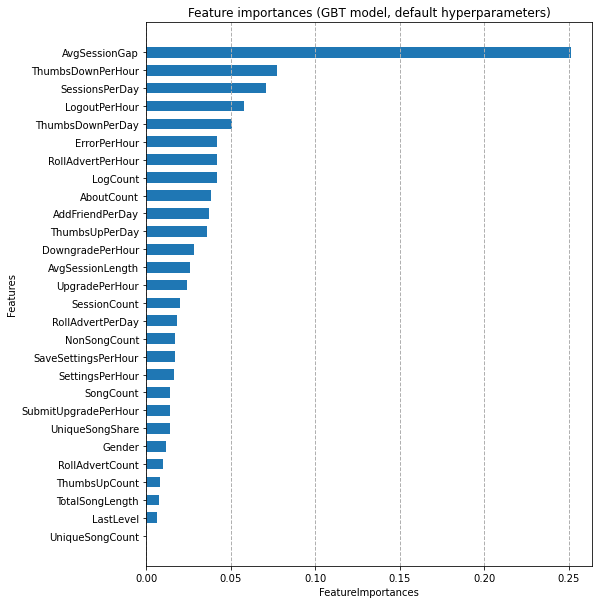

In [1362]:
# Plot feature importances
plot_feature_importance(data_gbt_28, model_gbt, 10, 'Feature importances (GBT model, default hyperparameters)')

#### Cross-validation

In [1365]:
# Create classifier
classifier = GBTClassifier()

# Define ParamGrid builder
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(classifier.maxIter, [10, 20, 50, 200]) \
    .addGrid(classifier.maxDepth,[2, 5]) \
    .addGrid(classifier.maxBins, [32]) \
    .build()

# Fit cross-validation model
model_cv, scores_cv = fit_model_cv(data_gbt_28, classifier, paramGrid_gbt)

# Show scores
scores_cv

Cross validation started. Please wait...
Train|Test data split done.
Create pipeline done.
Cross validation done (3680 s).


,maxIter,maxDepth,maxBins,score
0,10,2,32,0.785533
6,200,2,32,0.784102
2,20,2,32,0.769725
4,50,2,32,0.764250
7,200,5,32,0.757141
3,20,5,32,0.728375
5,50,5,32,0.728375
1,10,5,32,0.724253


#### Model #02 (best cv model)
> - *28 features*
> - *seed 0*
> - *GBTClassifier*
> - *maxIter=10, maxDepth=2, maxBins=32*

In [1366]:
classifier = GBTClassifier(maxIter=10, maxDepth=2, maxBins=32)
model_gbt_cvbest, metrics_gbt_cvbest = fit_model(data_gbt_28, classifier)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (812 s).


In [1367]:
metrics_gbt_cvbest

,metrics value
F1,0.907345
accuracy,0.909091
weighted precision,0.907727
weighted recall,0.909091
AUC,0.868056


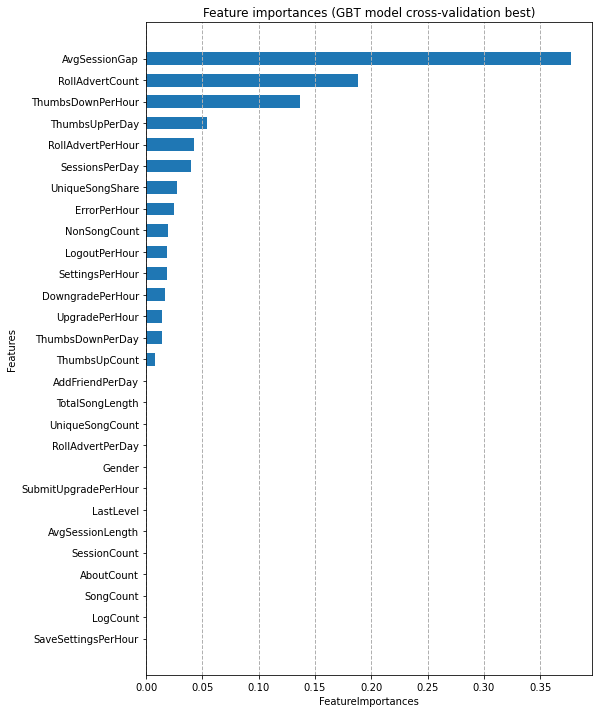

In [1369]:
# Plot feature importances
plot_feature_importance(data_gbt_28, model_gbt_cvbest, 12, 'Feature importances (GBT model cross-validation best)')

*SEED EXERCISES:*

<small><em>The following notebook code is imported from [Sparkify-modeling.ipynb](Sparkify-modeling.ipynb) notebook. Some minor code refactoring has been done on imported code.</em></small>

### Random Forest

In [182]:
# Model's data (17 features)
data_rfc_5c = data_labels.join(f_LogCount, 'userId', 'outer') \
    .join(f_NonSongCount, 'userId', 'outer') \
    .join(f_ThumbsUpCount, 'userId', 'outer') \
    .join(f_RollAdvertCount, 'userId', 'outer') \
    .join(f_SessionCount, 'userId', 'outer') \
    .join(f_AvgSessionLength, 'userId', 'outer') \
    .join(f_AvgSessionGap, 'userId', 'outer') \
    .join(f_DowngradePerSessionHour, 'userId', 'outer') \
    .join(f_SettingsPerSessionHour, 'userId', 'outer') \
    .join(f_LogoutPerSessionHour, 'userId', 'outer') \
    .join(f_RollAdvertPerHour, 'userId', 'outer') \
    .join(f_ThumbsDownPerHour, 'userId', 'outer') \
    .join(f_SessionsPerDay, 'userId', 'outer') \
    .join(f_AddFriendPerDay, 'userId', 'outer') \
    .join(f_RollAdvertPerDay, 'userId', 'outer') \
    .join(f_ThumbsDownPerDay, 'userId', 'outer') \
    .join(f_ThumbsUpPerDay, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

<a id="section-mini-bestmodel"></a>
#### Model #03
> - *17 features*
> - *seed 5*
> - *RandomForestClassifier*
> - *default hyperparameters*

In [258]:
classifier = RandomForestClassifier(seed=5)
model_rfc_5c, metrics_rfc_5c = fit_model(data_rfc_5c, classifier, seed=5)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (771 s).


In [259]:
metrics_rfc_5c

,metrics value
F1,0.928398
accuracy,0.930233
weighted precision,0.928202
weighted recall,0.930233
AUC,0.860714


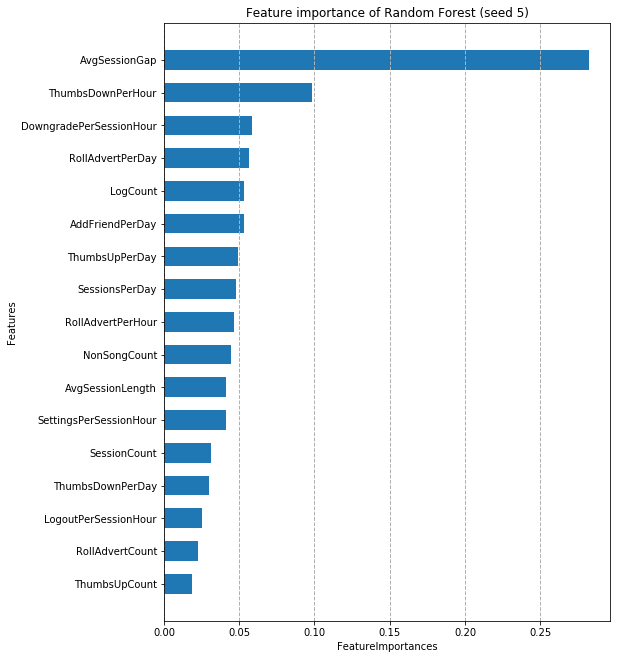

In [265]:
plot_feature_importance(data_rfc_5c, model_rfc_5c, 9, 'Feature importance of Random Forest (seed 5)')

#### Cross-Validation

In [214]:
# Model's data (29 features)
# Remark: Submit Downgrade event included
data_rfc_29 = data_labels.join(f_Gender, 'userId', 'outer') \
    .join(f_LastLevel, 'userId', 'outer') \
    .join(f_LogCount, 'userId', 'outer') \
    .join(f_SongCount, 'userId', 'outer') \
    .join(f_NonSongCount, 'userId', 'outer') \
    .join(f_AboutCount, 'userId', 'outer') \
    .join(f_ThumbsUpCount, 'userId', 'outer') \
    .join(f_RollAdvertCount, 'userId', 'outer') \
    .join(f_SessionCount, 'userId', 'outer') \
    .join(f_AvgSessionLength, 'userId', 'outer') \
    .join(f_AvgSessionGap, 'userId', 'outer') \
    .join(f_DowngradePerSessionHour, 'userId', 'outer') \
    .join(f_ErrorPerSessionHour, 'userId', 'outer') \
    .join(f_SettingsPerSessionHour, 'userId', 'outer') \
    .join(f_SaveSettingsPerSessionHour, 'userId', 'outer') \
    .join(f_LogoutPerSessionHour, 'userId', 'outer') \
    .join(f_SubmitDowngradePerSessionHour, 'userId', 'outer') \
    .join(f_RollAdvertPerHour, 'userId', 'outer') \
    .join(f_ThumbsDownPerHour, 'userId', 'outer') \
    .join(f_UpgradePerHour, 'userId', 'outer') \
    .join(f_SubmitUpgradePerHour, 'userId', 'outer') \
    .join(f_SessionsPerDay, 'userId', 'outer') \
    .join(f_AddFriendPerDay, 'userId', 'outer') \
    .join(f_RollAdvertPerDay, 'userId', 'outer') \
    .join(f_ThumbsDownPerDay, 'userId', 'outer') \
    .join(f_ThumbsUpPerDay, 'userId', 'outer') \
    .join(f_TotalSongLength, 'userId', 'outer') \
    .join(f_UniqueSongCount, 'userId', 'outer') \
    .join(f_UniqueSongShare, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

In [294]:
# Create classifier
classifier = RandomForestClassifier(seed=0)

# Define ParamGrid builder
paramGrid_rfc = ParamGridBuilder() \
    .addGrid(classifier.maxDepth, [4, 5, 6]) \
    .addGrid(classifier.numTrees, [10, 20, 50]) \
    .build()

# Fit cross-validation model
model_rfc_cv, scores_rfc_cv = fit_model_cv(data_rfc_29, classifier, paramGrid_rfc)

# Show scores
scores_rfc_cv

Cross validation started. Please wait...
Cross validation done (1739 s).

Cross validation parameters ordered by score, descending:


,maxDepth,numTrees,score
7,6,20,0.759634
2,4,50,0.758248
8,6,50,0.756516
3,5,10,0.754577
4,5,20,0.752732
5,5,50,0.748812
6,6,10,0.745256
0,4,10,0.725191
1,4,20,0.722808


#### Model #04 (best cv model)
> - *29 features*
> - *seed 0*
> - *RandomForestClassifier*
> - *maxDepth=6, numTrees=20*

In [357]:
classifier = RandomForestClassifier(seed=0, maxDepth=6, numTrees=20)
model_rfc_cvbest, metrics_rfc = fit_model(data_rfc, classifier)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (1456 s).


In [356]:
# Show metrics
metrics_rfc

,metrics value
F1,0.912889
accuracy,0.920000
weighted precision,0.912609
weighted recall,0.920000
AUC,0.738636


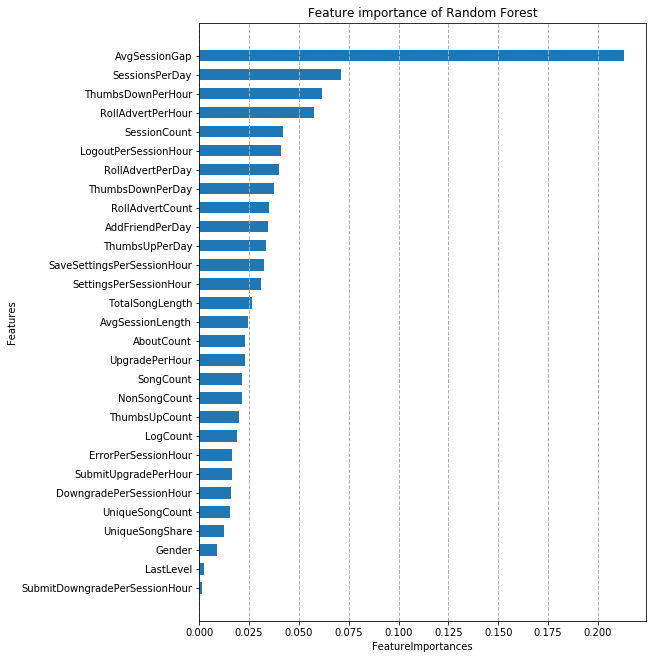

In [336]:
plot_feature_importance(data_rfc_29, model_rfc_cvbest, 9, 'Feature importance of Random Forest')

### Logistic Regression

In [295]:
# Model's data (8 features)
data_lr_8 = data_labels.join(f_AvgSessionGap, 'userId', 'outer') \
    .join(f_SessionsPerDay, 'userId', 'outer') \
    .join(f_ThumbsDownPerHour, 'userId', 'outer') \
    .join(f_RollAdvertPerHour, 'userId', 'outer') \
    .join(f_SessionCount, 'userId', 'outer') \
    .join(f_LogoutPerSessionHour, 'userId', 'outer') \
    .join(f_RollAdvertPerDay, 'userId', 'outer') \
    .join(f_ThumbsDownPerDay, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

#### Model #05
> - *8 features*
> - *seed 0*
> - *LogisticRegression*
> - *default hyperparameters*

In [381]:
classifier = LogisticRegression(featuresCol='features', labelCol = 'label')
model_lr, metrics_lr = fit_model(data_lr_8, classifier)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (468 s).


In [382]:
metrics_lr

,metrics value
F1,0.856190
accuracy,0.840000
weighted precision,0.884000
weighted recall,0.840000
AUC,0.765152


#### Cross-Validation

In [385]:
# Create classifier
classifier = LogisticRegression(featuresCol='features', labelCol = 'label')

# Define ParamGrid builder
paramGrid_lr = ParamGridBuilder() \
    .addGrid(classifier.maxIter, [10, 20]) \
    .addGrid(classifier.regParam, [0.0, 0.1]) \
    .addGrid(classifier.elasticNetParam, [0.0, 0.5]) \
    .build()

# Fit cross-validation model
model_lr_cv, scores_lr_cv = fit_model_cv(data_lr_8, classifier, paramGrid_lr)

# Show scores
scores_lr_cv

Cross validation started. Please wait...
Cross validation done (1810 s).

Cross validation parameters ordered by score, descending:


,elasticNetParam,maxIter,regParam,score
2,0.0,10,0.1,0.807631
6,0.0,20,0.1,0.794845
4,0.0,20,0.0,0.794637
5,0.5,20,0.0,0.794637
0,0.0,10,0.0,0.793251
1,0.5,10,0.0,0.793251
3,0.5,10,0.1,0.772826
7,0.5,20,0.1,0.770787


#### Model #06 (best cv model)
> - *8 features*
> - *seed 0*
> - *LogisticRegression*
> - *elasticNetParam=0.0, maxIter=10, regParam=0.1*

In [386]:
classifier = LogisticRegression(featuresCol='features', labelCol='label', \
                                elasticNetParam=0.0, maxIter=10, regParam=0.1)
model_lr_cvbest, metrics_lr_cvbest = fit_model(data_lr_8, classifier)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (502 s).


In [387]:
metrics_lr_cvbest

,metrics value
F1,0.896016
accuracy,0.900000
weighted precision,0.893333
weighted recall,0.900000
AUC,0.727273


### Seed results

We also tried fitting the models with the same *features*, same *learning method* and *hyperparameters*, but with different random split's **seed value**. Since our model data is very small (225 rows), it has outliers and the churn class is imbalanced we were expecting different seed results. And it was precisely what happened. 

In [70]:
# List of learning methods with number of features
# Note: The metric values have been collected from the source notebook.

seed_method_features = ['Random Forest (29f)', 
               'Random Forest (20f)', 
               'Random Forest (17f)', 
               'GBTClassifier (19f)', 
               'Logistic Regression (8f)']

seed_seed = [0, 5, 47, 99]
seed_method_rf_29f = [0.9129, 0.8605, 0.8643, 0.8799]
seed_method_rf_20f = [0.8715, 0.8218, 0.9054, 0.8799]
seed_method_rf_17f = [0.8715, 0.9284, 0.8333, 0.8678]
seed_method_gbt_19f = [0.8960, 0.8218, 0.7572, 0.8199]
seed_method_lr_8f = [0.8960, 0.8605, 0.8643, 0.8799]

seed_results_df = pd.DataFrame({
    'seed': seed_seed,
    'Random Forest (29f)': seed_method_rf_29f,
    'Random Forest (20f)': seed_method_rf_20f,
    'Random Forest (17f)': seed_method_rf_17f,
    'GBTClassifier (19f)': seed_method_gbt_19f,
    'Logistic Regression (8f)': seed_method_lr_8f
})

seed_results = seed_results_df.set_index('seed')
seed_results

,Random Forest (29f),Random Forest (20f),Random Forest (17f),GBTClassifier (19f),Logistic Regression (8f)
seed,,,,,
0,0.9129,0.8715,0.8715,0.8960,0.8960
5,0.8605,0.8218,0.9284,0.8218,0.8605
47,0.8643,0.9054,0.8333,0.7572,0.8643
99,0.8799,0.8799,0.8678,0.8199,0.8799


In [65]:
# The average performance per method
seed_results.mean()

Random Forest (29f)         0.879400
Random Forest (20f)         0.869650
Random Forest (17f)         0.875250
GBTClassifier (19f)         0.823725
Logistic Regression (8f)    0.875175
dtype: float64

In [66]:
# The average performance per seed
seed_results.T.mean()

seed
0     0.88958
5     0.85860
47    0.84490
99    0.86548
dtype: float64

#### Best model results
Here are the results of best model performance, one per learning method:

In [58]:
# Note: The metric values have been collected from the source notebook.

best_method = ['Random Forest', 'GBTClassifier', 'Logistic Regression']
best_F1 = [0.928398, 0.907345, 0.896016]
best_accuracy = [0.930233, 0.909091, 0.900000]
best_weighted_precision = [0.928202, 0.907727, 0.893333]
best_weighted_recall = [0.930233, 0.909091, 0.900000]
best_AUC = [0.860714, 0.868056, 0.727273]

results_df = pd.DataFrame({
    'method': best_method,
    'F1': best_F1,
    'accuracy': best_accuracy,
    'weighted precision': best_weighted_precision,
    'weighted recall': best_weighted_recall,
    'AUC': best_AUC
})

results = spark.createDataFrame(results_df)
results.show(truncate=False)

+-------------------+--------+--------+------------------+---------------+--------+
|method             |F1      |accuracy|weighted precision|weighted recall|AUC     |
+-------------------+--------+--------+------------------+---------------+--------+
|Random Forest      |0.928398|0.930233|0.928202          |0.930233       |0.860714|
|GBTClassifier      |0.907345|0.909091|0.907727          |0.909091       |0.868056|
|Logistic Regression|0.896016|0.9     |0.893333          |0.9            |0.727273|
+-------------------+--------+--------+------------------+---------------+--------+



### Extra fitting #1: Attempt to improve results of the best model using correlation analysis

Usually, the correlation analysis precedes the feature engineering. Our path was different. We engineered a big corpus of features based on delta calculation, we procedeed with the modelling and then we let the fitted model, where possible, to supply  the information about the feature importances which - with several iterations - we used to re-select features and improve the model. 

Now we use our best model from the sample dataset to carry out the correlation analysis. It will be interesting to see what improvements, if any, we can make.

#### Plot correlation coefficients of the best model

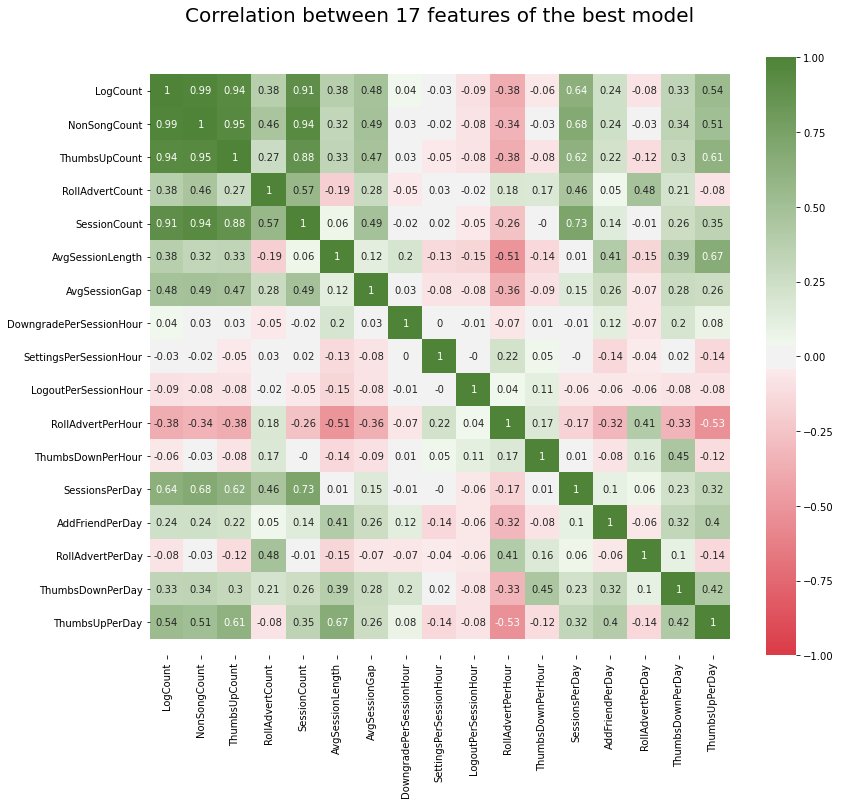

In [222]:
corr_df = data_rfc_5c.toPandas()

# Plot correlation heatmap
plt.figure(figsize = [13, 11])
plt.title('Correlation between 17 features of the best model', y=1.05, size=20)
ax = sb.heatmap(corr_df.iloc[:, 1:].corr().round(2), annot=True, 
                cmap = sb.diverging_palette(10, 120, as_cmap = True),
                vmin = -1, vmax = 1)
plt.yticks(rotation = 0)

# Correct plot cut off (Note: we must fix it due to the bug in the matplotlib 3.1.1)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

#### List of correlation coefficient mean

In [239]:
# Create a list of correlation coefficient mean (using absolute values)
# ordered from weaker to stronger correlation

corr = corr_df.iloc[:, 1:].corr()
corr.apply(lambda x : np.mean(abs(x))).sort_values()

DowngradePerSessionHour    0.116517
SettingsPerSessionHour     0.116830
LogoutPerSessionHour       0.120635
ThumbsDownPerHour          0.160989
RollAdvertPerDay           0.179264
AddFriendPerDay            0.244844
RollAdvertCount            0.287148
AvgSessionGap              0.292955
AvgSessionLength           0.304191
ThumbsDownPerDay           0.309314
SessionsPerDay             0.309866
RollAdvertPerHour          0.332740
ThumbsUpPerDay             0.368233
SessionCount               0.393601
ThumbsUpCount              0.431072
NonSongCount               0.439024
LogCount                   0.442314
dtype: float64

#### Interpretation

The green zones represent the *positive correlation*: the more intense the green color, the stronger positive correlation between the variables. Similarly, the red zones represent the *negative correlation*: the more intense the red color, the stronger negative correlation between the variables. The bright grey colors represent zones with *weak correlation*.

By observing these zones we can detect variables that are **weakly correlated** and will be deselected from our list of selected features. This observation is also in accordance with the upper list of variables ordered by *correlation coefficient mean*:

> - *DowngradePerSessionHour* 
> - *SettingsPerSessionHour*
> - *LogoutPerSessionHour*
> - *ThumbsDownPerHour*
> - *RollAdvertPerDay*

We can find two variables with similar correlation coefficients:

> - *LogCount*
> - *NonSongCount*

These two variables have a **very strong relationship** with each other. Their coefficient is **0.99** and the coefficients with other variables are very alike. Their strong similarity is also confirmed by the coefficient mean - **0.442314** vs. **0.439024**. Obviously, they are *dependent* variables. We don't need to use both of them - one is enough. And we choose *LogCount* since it has a bit higher correlation mean while *NonSongCount* gets deselected.

So, from the initial **17 features** of the best model in the sample dataset we remove 6 features. With the rest of **11 features** we'll exercise 4 more model fittings, one per seed, using the same classifier (*Random Forest*) from the best model.   

In [202]:
# Model's data - 11 features - based on correlation analysis of the best model
data_rfc_corr_11 = data_labels.join(f_LogCount, 'userId', 'outer') \
    .join(f_ThumbsUpCount, 'userId', 'outer') \
    .join(f_RollAdvertCount, 'userId', 'outer') \
    .join(f_SessionCount, 'userId', 'outer') \
    .join(f_AvgSessionLength, 'userId', 'outer') \
    .join(f_AvgSessionGap, 'userId', 'outer') \
    .join(f_RollAdvertPerHour, 'userId', 'outer') \
    .join(f_SessionsPerDay, 'userId', 'outer') \
    .join(f_AddFriendPerDay, 'userId', 'outer') \
    .join(f_ThumbsDownPerDay, 'userId', 'outer') \
    .join(f_ThumbsUpPerDay, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

#### Model fitting (per seed)

##### seed 0

In [203]:
classifier = RandomForestClassifier()
model_rfc_corr_11, metrics_rfc_corr_11 = fit_model(data_rfc_corr_11, classifier)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (346 s).


In [204]:
metrics_rfc_corr_11

,metrics value
F1,0.907345
accuracy,0.909091
weighted precision,0.907727
weighted recall,0.909091
AUC,0.868056


##### seed 5

In [223]:
classifier = RandomForestClassifier(seed=5)
model_rfc_corr_11_5, metrics_rfc_corr_11_5 = fit_model(data_rfc_corr_11, classifier, seed=5)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (307 s).


In [224]:
metrics_rfc_corr_11_5

,metrics value
F1,0.853659
accuracy,0.853659
weighted precision,0.853659
weighted recall,0.853659
AUC,0.707143


##### seed 47

In [229]:
classifier = RandomForestClassifier(seed=47)
model_rfc_corr_11_47, metrics_rfc_corr_11_47 = fit_model(data_rfc_corr_11, classifier, seed=47)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (350 s).


In [230]:
metrics_rfc_corr_11_47

,metrics value
F1,0.892680
accuracy,0.897436
weighted precision,0.894918
weighted recall,0.897436
AUC,0.816667


##### seed 99

In [233]:
classifier = RandomForestClassifier(seed=99)
model_rfc_corr_11_99, metrics_rfc_corr_11_99 = fit_model(data_rfc_corr_11, classifier, seed=99)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (341 s).


In [235]:
metrics_rfc_corr_11_99

,metrics value
F1,0.888966
accuracy,0.902439
weighted precision,0.912986
weighted recall,0.902439
AUC,0.750000


#### Feature importances

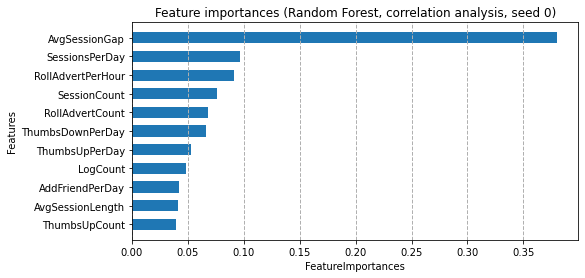

In [248]:
plot_feature_importance(data_rfc_corr_11, model_rfc_corr_11, 4, 
                        'Feature importances (Random Forest, correlation analysis, seed 0)')

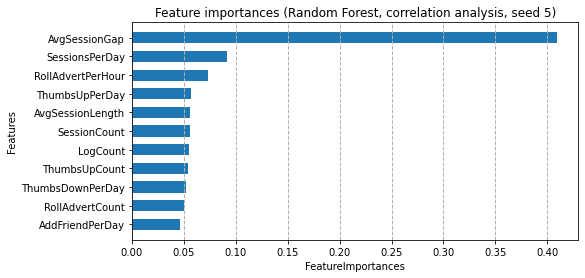

In [247]:
plot_feature_importance(data_rfc_corr_11, model_rfc_corr_11_5, 4, 
                        'Feature importances (Random Forest, correlation analysis, seed 5)')

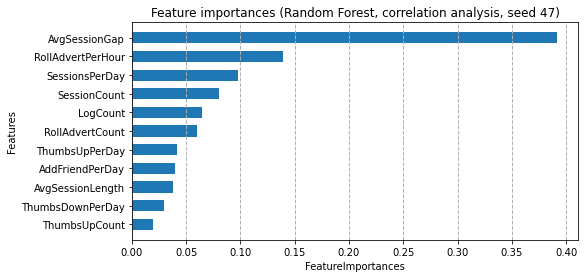

In [246]:
plot_feature_importance(data_rfc_corr_11, model_rfc_corr_11_47, 4, 
                        'Feature importances (Random Forest, correlation analysis, seed 47)')

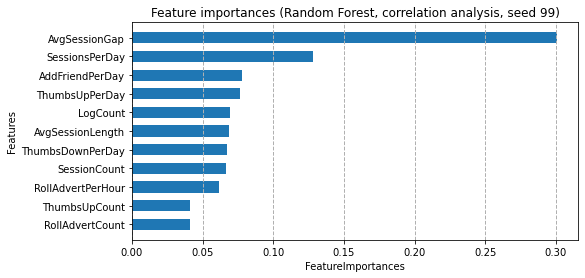

In [245]:
plot_feature_importance(data_rfc_corr_11, model_rfc_corr_11_99, 4, 
                        'Feature importances (Random Forest, correlation analysis, seed 99)')

### Extra fitting #2: Using a single, premium feature (AvgSessionGap)

The next extra fitting test was done with only one feature - **AvgSessionGap** - using the Random Forest method on all seeds. The result demonstrated the importance of a premium predictor for the churn type of cancelled users. We have achieved an average cross-seed F1-score of **0.878877** and **0.919977** at best (seed 99)! This result can be compared with another important predictor - **RollAdvertCount** where we got **0.717864** (seed 99). More than 0.2 of difference between the predictors on the same seed is very indicative.

In [ ]:
# Model's data with a single, premium feature
data_premium = data_labels.join(f_AvgSessionGap, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

#### AvgSessionGap

##### seed 0

In [297]:
classifier = RandomForestClassifier()
model_rfc_premium, metrics_rfc_premium = fit_model(data_premium, classifier)
metrics_rfc_premium

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (109 s).


,metrics value
F1,0.878788
accuracy,0.878788
weighted precision,0.878788
weighted recall,0.878788
AUC,0.847222


##### seed 5

In [302]:
classifier = RandomForestClassifier(seed=5)
model_rfc_premium_5, metrics_rfc_premium_5 = fit_model(data_premium, classifier, seed=5)
metrics_rfc_premium_5

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (114 s).


,metrics value
F1,0.815946
accuracy,0.804878
weighted precision,0.830931
weighted recall,0.804878
AUC,0.678571


##### seed 47

In [303]:
classifier = RandomForestClassifier(seed=47)
model_rfc_premium_47, metrics_rfc_premium_47 = fit_model(data_premium, classifier, seed=47)
metrics_rfc_premium_47

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (131 s).


,metrics value
F1,0.900796
accuracy,0.897436
weighted precision,0.909590
weighted recall,0.897436
AUC,0.894444


##### seed 99

In [304]:
classifier = RandomForestClassifier(seed=99)
model_rfc_premium_99, metrics_rfc_premium_99 = fit_model(data_premium, classifier, seed=99)
metrics_rfc_premium_99

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (119 s).


,metrics value
F1,0.919977
accuracy,0.926829
weighted precision,0.932927
weighted recall,0.926829
AUC,0.812500


#### RollAdvertCount, *seed 99*

In [308]:
# Model's data with a single, f_RollAdvertCount feature
data_RollAdvertCount = data_labels.join(f_RollAdvertCount, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

In [309]:
classifier = RandomForestClassifier(seed=99)
model_rfc_rolladvert_99, metrics_rfc_rolladvert_99 = fit_model(data_RollAdvertCount, classifier, seed=99)
metrics_rfc_rolladvert_99

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.
Training done.
Metrics prepared.
Model fitting done (93 s).


,metrics value
F1,0.717864
accuracy,0.804878
weighted precision,0.647829
weighted recall,0.804878
AUC,0.500000


### Summary on mini dataset

 - The initial **full feature selection** was made using the *general statistical method* as described [above](#section-general-statistical-method). Upon preliminary tests some features confirmed by the general statistical method were discarded and replaced by the features whose *delta value* was below the delta threshold.
 - We have exercised the modelling with several feature subsets with *different quantity and selection* (8, 17, 19, 20, 28, 29). Normally, the next feature subset was selected according to the evaluation results of the previous feature subset (*feature importances*).  
 - Three machine learning methods were used:
  + *Random Forest*
  + *GBTClassifier*
  + *Logistic Regression*
 - The [best model](#section-mini-bestmodel) achieved the F1 score **0.9284** using *Random Forest* learning method with default hyperparameters.
 - Best 3 features:
  + *AvgSessionGap* (leads in all results with more than *0.20 importance score* as our **premium feature**)
  + *ThumbsDownPerHour* (appears in all lists of top 5 features)
  + *RollAdvertPerHour*


In the final part, we have made two extra fittings:
 - An attempt to improve our scores by *correlation analysis*. Although we haven't improved the best model's result (**0.9284**) we succeeded to increase the seed average from **0.8794** (Random Forest, 29 features) to **0.8857** (11 features). We have also improved the *standard deviation* of seed results between the both models: **0.0197** (11 features) vs. **0.0207** (29 features).
 - The cross-seed tests with a single feature (*AvgSessionGap* and *RollAdvertCount*) demonstrated the importance of the **AvgSessionGap** premium predictor for the churn type of cancelled users with **0.919977** at best.

##### Critical remark

> *Having done several model fitting exercises with different feature selections, random split seeds, learning methods, and hyperparameters, we have come to the conclusion that the mini dataset is **too small for the reliable prediction results**.*  

Let's demonstrate mathematically why our small sample affects the prediction ability by observing our principal evaluation metric **F1-score**. We'll calculate the difference between F1 scores of two similar models M and M' with the smallest change in *true positives* (TP), *true negatives* (TN), *false positives* (FP), and *false negatives* (FN) values. To simplify the calculation let us suppose that the first model M is perfectly fitted:

> $FP = 0$ and $FN = 0$

> $F_1 = precision = recall = 1.0$

**Example A: Minimum decrement of TP**

> $TP' = TP - 1$

If the TP value decreases by 1, then one positive instance in the model M has been converted into one incorrectly classified negative instance in the model M', that is, 1 TP has been converted into 1 FN. So, by decrementing *true positives* we increase false predictions and introduce a certain amount of **FN error** (*type II error*) in the perfect model.

> $FN' = FN + 1$

The other two values, FP and TN, remain unchanged.

> $FP' = FP = 0$

> $TN' = TN$

The *precision (p)*  and *recall (r)* of the second model is:

> $p' = \frac{TP'}{TP'+FP'} = \frac{TP-1}{TP-1+0} = 1.0 = p$

> $r' = \frac{TP'}{TP'+FN'} = \frac{TP-1}{TP-1+FN+1} = \frac{TP-1}{TP-0} = 1 - \frac{1}{TP}$

**The recall decreases** while the precision doesn't change.

> $r' < r$

The F1 score of the second model is:

> $F_1' = 2\frac{p'r'}{p'+r'} = 2\frac{r'}{r'+1}$ 

Our mini dataset has **225 users**, so is the number of rows in our model dataset (before split). Suppose that when 80:20 split is done our training dataset has **184** users out of which **8** are churned users. This gives

> $F_1' = \frac{14}{15}$

and 

> $F_1 - F_1' = \frac{1}{15} = 0.0667$ 

**Example B: Minimum increment of FP**

While the previous example shows that a FN error is introduced in the model M by increasing the value of *false negatives* which is the same as decreasing the value of *true positives*, we can also increase the value of *false positives* and the effect - to "damage" the perfect model introducing a **FP error** (*type I error*) -  would be similar. 

> $FP' = FP + 1$

If the FP value increases by 1, then its TN counterpart must decrease by 1. 

> $TN' = TN - 1$

The other two values, TP and FN, remain unchanged.

> $TP' = TP$

> $FN' = FN = 0$

Then

> $p' = \frac{TP'}{TP'+FP'} = \frac{TP}{TP+FP+1} => \frac{1}{p'} = \frac{1}{1+\frac{1}{TP}}$

> $r' = \frac{TP'}{TP'+FN'} = \frac{TP}{TP+FN} = 1.0 = r$

Here **the precision decreases** while the recall remains the same.

> $p' < p$

Then

> $F_1' = \frac{2}{\frac{1}{p'}+\frac{1}{r'}} = \frac{2}{2+\frac{1}{TP}}$

If we calculate the F1 score with the identical values as in the example A we get:

> $F_1' = \frac{16}{17}$

and 

> $F_1 - F_1' = \frac{1}{17} = 0.0588$ 

Comparing the two models M and M', supposing the first model M is perfect, if only one *true positive* from M changes to a *false negative* the F1 score of M' drops by **6.66%**, or if only one *true negative* from M changes to a *false positive* the F1 score drops by **5.88%**. 

It is quite a change. If we would use the full dataset with **5000** churned users the F1 score difference would be much less - around **0.01%**:

> (A) $r' = 1 - \frac{1}{5000}, F_1' = 2\frac{r'}{r'+1} = 0.999989$

> (B) $F_1' = \frac{2}{2+\frac{1}{TP}} = \frac{2}{2+\frac{1}{5000}} = 0.999900$

**Conclusion**

Our sample dataset represents only 1/100 of data from the original dataset which is *a very small portion*. Hence each random data split generates **seed-specific data** where outliers impact a lot the model and cause that the results change substantially when the seed value changes. A good example is the GBTClassifier with 19 features and default hyperparameters whose F1-score was altering on interval [0.7572, 0.8960] under different seed values. 

The models with low quantity of data are more prone to have **higher variance** and, therefore, are more prone to **overfitting** which is exactly what we have experienced when modelling *seed-specific data*. Being the model fitting so "unstable" and "sensible" to slightest changes in random data split we found the sample dataset **unsuitable for model tuning**. If we achieve good results under a certain seed this doesn't mean that we can expect the same results with other splits.

**This conclusion also insinuates that we have to move to the cluster**, repeat the exploratory data analysis there, adjust the feature engineering, exercise and tune the model accordingly using the full dataset in order to confirm (or reject) our results achieved here by the sample dataset.

**Additional remark**

The *cross-seed improvement* based on correlation analysis of the best model does not change our opinion. We indeed achieved a slightly more stable predictions but the differences in F1 scores between the seeds were still there. What was demonstrated was that there is always room for fine tuning even if the dataset does not facilitate it.

## Big dataset
> - size: **12GB**
> - row count: **26,259,199**
> - user count: **22,278**:
>  - *5,003 cancelled users*
>  - *5,103 downgraded users*
> - data source: **s3n://udacity-dsnd/sparkify/sparkify_event_data.json**
> - executed on: **Amazon EMR cluster**

*EXERCISES ON CLUSTER:*

<small><em>The following notebook code is imported from the various notebooks that were executed on the EMR cluster. Some minor code refactoring has been done on imported code.</em></small>

> - The delta values revision has been done (**data re-examination**).
> - New features added (**feature re-engineering**).
> - The **both churn types** are included: *cancelled* and *downgraded* users.
> - There is a **clear difference** between selected features for both churn types.

### Churn type A: Cancelled users
Source notebook: [Sparkify-cluster-cancelled-feature-engineering.ipynb](Sparkify-cluster-cancelled-feature-engineering.ipynb)

The delta threshold for the *cancelled users* was set to

> $|\Delta| > 0.10$

#### Selected features (22 features)

In [123]:
spark.sparkContext.parallelize(selected_features).toDF(['delta', 'feature']) \
    .select('feature', 'delta', Fabs(col('delta'))) \
    .sort(desc('abs(delta)')) \
    .show(30, False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------------+--------------------+-------------------+
|feature                |delta               |abs(delta)         |
+-----------------------+--------------------+-------------------+
|LogoutPerHour          |-0.7009141698785681 |0.7009141698785681 |
|AboutCount             |-0.38340983612658475|0.38340983612658475|
|ErrorPerSessionHour    |-0.3678621672272629 |0.3678621672272629 |
|SettingsPerSessionHour |0.34679195799886436 |0.34679195799886436|
|AvgSessionGap          |-0.3077974665435747 |0.3077974665435747 |
|DowngradePerSessionHour|0.3055908818093422  |0.3055908818093422 |
|SessionCount           |-0.29887121266740024|0.29887121266740024|
|HomeCount              |-0.2505802918282092 |0.2505802918282092 |
|RollAdvertPerHour      |0.21758242517045812 |0.21758242517045812|
|HomePerHour            |-0.21274324671988146|0.21274324671988146|
|SettingsPerHour        |0.1609912158149237  |0.1609912158149237 |
|SubmitUpgradePerHour   |0.14212149688291761 |0.14212149688291

2 features below the threshold were selected as well: *RollAdvertCount* and *ThumbsUpCount*.

#### Preliminary fitting test: Random Forest method
We created 3 preliminary models with features used in the sample mini dataset. The first impression was that there was still room for feature engineering since the models in the preliminary exercises were performed below average of the fitting results from the mini dataset.

A new set of features adjusted to the big dataset was designed. The 4th *Random Forest* model was fitted as shown below:  

In [4]:
metrics = spark.read.json('s3n://amosvoron-sparkify/rfc-metrics-f22.json')
metrics.select('f1', 'accuracy', 'weightedPrecision', 'weightedRecall', 'AUC').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+------------------+-----------------+------------------+------------------+
|                f1|          accuracy|weightedPrecision|    weightedRecall|               AUC|
+------------------+------------------+-----------------+------------------+------------------+
|0.8386651060216977|0.8577847674679847|0.858875141192138|0.8577847674679848|0.7055267657733111|
+------------------+------------------+-----------------+------------------+------------------+

In [9]:
importances = spark.read.json('s3n://amosvoron-sparkify/rfc-feature-importances-f22.json')
importances.sort(desc('importance')).show(30, False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------------+---------------------+
|feature                |importance           |
+-----------------------+---------------------+
|AvgSessionGap          |0.531326926781188    |
|RollAdvertPerHour      |0.07203686762635017  |
|DowngradePerHour       |0.06676894742434188  |
|SessionCount           |0.062376199033023286 |
|NonSongCount           |0.050628344100157416 |
|RollAdvertPerDay       |0.04571131362963781  |
|RollAdvertCount        |0.03022773918358667  |
|DowngradePerSessionHour|0.023059199682565503 |
|ThumbsDownPerHour      |0.021905197950220757 |
|HomeCount              |0.01935741525646098  |
|LogoutPerHour          |0.014225091004298893 |
|ThumbsUpCount          |0.014185526067462045 |
|SettingsPerSessionHour |0.011980284038583023 |
|AboutCount             |0.00900477412830605  |
|SubmitUpgradePerHour   |0.006285279375803763 |
|SettingsPerHour        |0.005847270443837536 |
|SubmitDowngradePerHour |0.004204600333886947 |
|UpgradePerSessionHour  |0.0030743231489

The preliminary test with big dataset features shows the promising result. Some features can be dropped. We can see that the **AvgSessionGap** feature bears *more than one half of the importance weight*, perhaps too much.

#### Models on cluster

> - 14 models
> - 3 learning methods: *Logistic Regression, Random Forest, GBTClassifier*
> - **Logistic Regression performed worse** than the other two methods: 0.774113 its best F1 score (with sample dataset features). We decided to cease to use this method after the second fitting with the big dataset features which was not quite promising: 0.750514.
> - **No cross-validation** took place on cluster. 
> - We tried **several hyperparameter** values along with **different feature subsets**.
> - **Only one seed** was used on cluster. 

<img src="images/cluster_cancelled_metrics.png" width="950" align="left" />

* The model Nº3 has only three features: *AvgSessionGap*, *SessionCount*, *LogoutPerHour*. The exercise with such a limited subset of features was made to confirm the importance of the **AvgSessionGap** feature what was demonstrated by the high F1 score (0.869747).

#### Best model metrics

> - *Model #10*
> - ***F1: 0.899433***
> - *22 features*
> - *GBTClassifier*
> - *hyperparameters*:
>  + *maxIter: 200*
>  + *maxDepth: 5*

<img src="images/cluster_cancelled_bestmodel_metrics.png" width="750" align="left" />

#### Best model feature importances

<img src="images/cluster_cancelled_bestmodel_importances.png" width="290" align="left" />

#### Extra fitting
We have exercised an additional fitting with *best model features from the sample dataset* which have been cleaned by correlation analysis and have given us better cross-seed result. *No improvements* here confirming that the feature selection on cluster was a separate job.

<img src="images/cluster_cancelled_corr_metrics.png" width="750" align="left" />

### Summary on cancelled users

 - The 3 most important features are **AvgSessionGap** (Δ=-0.3078, importance=0.1149), **NonSongCount** (Δ=-0.1239, importance=0.0649), **SessionCount** (Δ=-0.2989, importance=0.0608). All 3 features comply with the delta threshold of 0.10 for cancelled users.
 - The importance is more evenly distributed over the features than in the sample dataset.
 - The page events with the heighest prediction weight are: *Roll Advert*, *Thumbs Up*, *Thumbs Down*, *Settings*, *Downgrade*. 
 - What most contributes to predict a user that cancelled the subscription is:
   + **shorter time of inactivity**
   + exposure to **more advertising events**
   + **less thumbs up** and **more thumbs down** interactions
   + **more settings** interactions
   + **more downgrade** interactions

### Churn type B: Downgraded users
Source notebook: [Sparkify-cluster-downgraded-feature-engineering.ipynb](Sparkify-cluster-downgraded-feature-engineering.ipynb)

The delta threshold for the *downgraded users* was set to

> $|\Delta| > 0.10$

which is the same as for the cancelled users.

#### Selected features (28 features)

In [60]:
spark.sparkContext.parallelize(selected_features).toDF(['delta', 'feature']) \
    .select('feature', 'delta', Fabs(col('delta'))) \
    .sort(desc('abs(delta)')) \
    .show(40, False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------------+--------------------+-------------------+
|feature                   |delta               |abs(delta)         |
+--------------------------+--------------------+-------------------+
|LogoutPerHour             |-0.7456203412927254 |0.7456203412927254 |
|SongCount                 |0.43130639639912827 |0.43130639639912827|
|TotalSongLength           |0.43128280036240824 |0.43128280036240824|
|ErrorPerSessionHour       |-0.41005111724302395|0.41005111724302395|
|UniqueSongCount           |0.40992471481174186 |0.40992471481174186|
|LogCount                  |0.4091798464900924  |0.4091798464900924 |
|AddToPlaylistCount        |0.40249130515647424 |0.40249130515647424|
|LogoutCount               |0.3981348751928029  |0.3981348751928029 |
|ThumbsUpCount             |0.3889469104822356  |0.3889469104822356 |
|ThumbsDownCount           |0.3889322574829049  |0.3889322574829049 |
|AddFriendCount            |0.3838682562317078  |0.3838682562317078 |
|RollAdvertCount    

All selected features have delta *beyond the threshold*.

#### Models on cluster

> - 10 models
> - 2 learning methods: *Random Forest, GBTClassifier*
> - All two methods performed **similarly** reaching the best value of F1 score at more than **0.82**. Slightly better results were obtained by the *Random Forest* method.
> - **No cross-validation** took place on cluster. 
> - We tried **several hyperparameter** values along with **different feature subsets**.
> - **Only one seed** was used on cluster. 

<img src="images/cluster_downgraded_metrics.png" width="950" align="left" />

#### Best model metrics

> - *Model #24*
> - ***F1: 0.826829***
> - *15 features*
> - *Random Forest*
> - *hyperparameters*:
>  + *numTrees: 50*
>  + *maxDepth: 6*

<img src="images/cluster_downgraded_bestmodel_metrics.png" width="750" align="left" />

#### Best model feature importances

<img src="images/cluster_downgraded_bestmodel_importances.png" width="290" align="left" />

### Summary on downgraded users

- The 3 most important features are **RollAdvertCount** (Δ=-0.3726, importance=0.1958), **HomeCount** (Δ=0.1708, importance=0.1735), **NonSongCount** (Δ=0.3170, importance=0.1563). All 3 features comply with the delta threshold of 0.10 for cancelled users.
 - The page events with the heighest prediction weight are: *Roll Advert*, *Home*, *Logout*, *Thumbs Down*. 
 - What most contributes to predict a downgraded user is:
   + exposure to **more advertising events** in absolute count value but **less exposure per hour and per session hour**
   + **more home page interactions**
   + **more non-song activities** (activities not related directly to music streaming)

Please check the [Sparkify-cluster-results.ipynb](Sparkify-cluster-results.ipynb) notebook for the results on cluster.

## Final Conclusion

The most important: we have achieved our project goal - to reach F1 score of **0.9**. To be precise, *0.8994* on cluster and *0.9284* on sample dataset, both for *cancelled* users only. 

Not less important: we have learned a lot doing an exhaustive data examination and feature engineering. We pursued our objectives in extended modelling exercises fitting in total **24 models on cluster**. The *general statistical method* based on calculating the ratio difference of observed statistical values has been proven as a good approach. We were cautious over the fusion of both churn types into one churn group which was later confirmed on cluster as a good decision. We were reserved towards the fitting results obtained by the sample dataset which we found too small to give reliable predictions on imbalanced churn class due to the *overfitting* when training the same model with different subsets of randomly split data.   

The work on cluster was a separate world comparing to what we have done on local machine. We revised the feature selection from the sample dataset in order to use features that best suited the data on cluster. The fitting on cluster was very slow, on average more than 5 hours per model. Yet it was worth doing it. We have learned that reaching a certain result level like **0.85** of F1 score was not too complicated if the features are engineered and selected well, however, passing from **0.85** to **0.90** was much more challenging. We got the impression that more we were approaching the desired result more difficult it was to make the smallest steps forward. 

Another interesting observation was that having detected greater distinction factor *delta* in the sample dataset we set the delta threshold at **0.20**. With lower threshold there would be too many features to handle them. On cluster the delta threshold was set at **0.10** for both churn types. With higher threshold we would have collected too few features. The difference in delta threshold was indicating that the sample dataset lead to *higher variance* while the big dataset lead to *lower variance* and had provided us with more stable prediction results.

It was convenient perform *correlation analysis* after having already completed the fitting exercises. We could seen that there is still room for improvement which is always encouraging, however, the improvements on sample dataset do not necessarily mean improvements on big dataset. It was confirmed that the full dataset on cluster required its own feature engineering or at least a detailed revision. So by simply re-using the best model features from the sample dataset we haven't improved anything on cluster.   

If we compare the top 10 features of both churn types we notice only 3 features that both types share: *NonSongCount*, *RollAdvertCount*, *RollAdvertPerHour*. These 3 features contribute around **17%** of importance to the target of cancelled users and around **44%** of importance to the target of downgraded users. The average F1 score for cancelled users is **0.8574** and **0.8189** for downgraded users which makes the classification of the first target slightly better than the classification of the second one. We don't have a clear explanation where this difference comes from. Is it because the target of cancelled users **distincts better** from the target of downgraded users - "is it something in our data?" - or is it because we were missing some features with more weight to depict better the downgraded users?

Perhaps the most interesting occurence was the discovery of the premium predictor for the first target - **session gap** or **time of inactivity** - which was quite coincidental. In every model we fitted using Random Forest or GBTClassifier, either on sample dataset or on cluster, this predictor was always leading heavily over the rest of the predictors. The single predictor tests confirmed the high importance of the feature. What surprises is that it looks like the shorter time of inactivity which provides *no data at all* depicts better the cancelled users than any user activity providing *tons of data*.  

##### What can be improved

As we were lucky to discover the premium feature for cancelled users we might well have overlooked some features of similar importance that remained undiscovered. Especially the *downgraded* users seem to lack some predictors that could push the F1-score over 0.85. In the future, we should include the *correlation analysis* in feature engineering on cluster as well as more comprehensive *hyperparameter tuning* with cross-validation. 

## What can be improved

1.	As we were lucky to discover the premium feature for cancelled users we might well have *overlooked some features* of similar importance that remained undiscovered (or unselected). Especially the downgraded users seem to lack some predictors that could push the F1-score over 0.85. The delta analysis provided us with the features that not all entered in the preliminary modelling exercises like *SongCountPerDayOfWeek* and *SongCountPerHourOfDay* due to the excess of features that were initially collected. We could have invested more time in preliminary tests and paid more attention to final feature selection.  


2. We have seen how far it can take us a small well-selected subset of features. With a single premium predictor we achieved **0.919977** on sample dataset and **0.869747** with 3 features on cluster. And for these 3 features – *AvgSessionGap*, *SessionCount*, *LogoutPerHour*  –  we cannot really say that it was the optimum selection. The *SessionCount* was the 3rd most important feature and the *LogoutPerHour* was the 11th in the best cluster model. If we would have used the **correlation analysis** earlier, in the feature engineering, not after the modelling was already done, it could have helped us to reduce the quantity of the features and to find less more qualified features which might have improved our results.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.